# Project 03: Unsupervised Learning - Identify Customer Segments

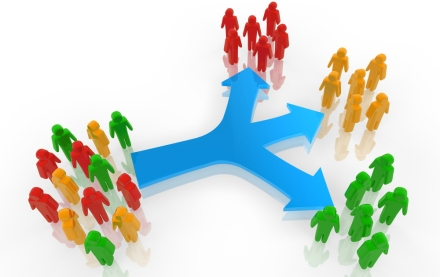


In this project, I will be applying unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that I will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.
At the end of most sections, here I will report my findings for the completed section, as well as document the decisions that I made in my approach to each subtask.

In [253]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline
import random
import time

from helper_functions2 import do_pca, plot_components
from helper_functions2 import scree_plot, plot_component, pca_results
from sklearn import preprocessing as p
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

Let's start off with loading all the datasets into a pandas DataFrame, and do the same for the feature attributes summary.

Once the dataset is loaded, we will browse the general structure of the dataset and feature summary file.

In [2]:
# Load in the general demographics data. Note: the .csv data files contain semicolon (;) delimiters
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', ';')

# Load in the Udacity customer data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', ';')

Let's check out the structure of the data after loading (e.g. number of rows and columns, print the first few rows).

In [3]:
print('The Udacity_AZDIAS dataset has {} rows and {} features.'.format(azdias.shape[0],azdias.shape[1]))
azdias.head(3)

The Udacity_AZDIAS dataset has 891221 rows and 85 features.


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0


In [4]:
azdias.isna().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [5]:
print('The Udacity_customer dataset has {} rows and {} features'.format(customers.shape[0],customers.shape[1]))
customers.head(3)

The Udacity_customer dataset has 191652 rows and 85 features


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0


In [6]:
customers.isna().sum()

AGER_TYP                     0
ALTERSKATEGORIE_GROB         0
ANREDE_KZ                    0
CJT_GESAMTTYP             3213
FINANZ_MINIMALIST            0
FINANZ_SPARER                0
FINANZ_VORSORGER             0
FINANZ_ANLEGER               0
FINANZ_UNAUFFAELLIGER        0
FINANZ_HAUSBAUER             0
FINANZTYP                    0
GEBURTSJAHR                  0
GFK_URLAUBERTYP           3213
GREEN_AVANTGARDE             0
HEALTH_TYP                   0
LP_LEBENSPHASE_FEIN       3213
LP_LEBENSPHASE_GROB       3213
LP_FAMILIE_FEIN           3213
LP_FAMILIE_GROB           3213
LP_STATUS_FEIN            3213
LP_STATUS_GROB            3213
NATIONALITAET_KZ             0
PRAEGENDE_JUGENDJAHRE        0
RETOURTYP_BK_S            3213
SEMIO_SOZ                    0
SEMIO_FAM                    0
SEMIO_REL                    0
SEMIO_MAT                    0
SEMIO_VERT                   0
SEMIO_LUST                   0
                         ...  
OST_WEST_KZ              49927
WOHNLAGE

In [7]:
print('The AZDIAS_feature summary dataset has {} rows and {} features'.format(feat_info.shape[0],feat_info.shape[1]))
feat_info.head(3)

The AZDIAS_feature summary dataset has 85 rows and 4 features


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"


In [8]:
feat_info.isna().sum()

attribute             0
information_level     0
type                  0
missing_or_unknown    0
dtype: int64

Summary of the datasets dimensions are:
- Udacity_AZDIAS dataset has 891221 rows and 85 features
- Udacity_customer dataset has 191652 rows and 85 features
- AZDIAS_feature summary dataset has 85 rows and 4 features

Also, running the 'isNa sum' function on both the Azdias and Customer datasets we found that there is multiple columns that already contain baked in NaN values that will have to be added to our efforts later on.

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

Lets start my looking at the distribution fo the unique values of each of the four columns in Feat_info table.

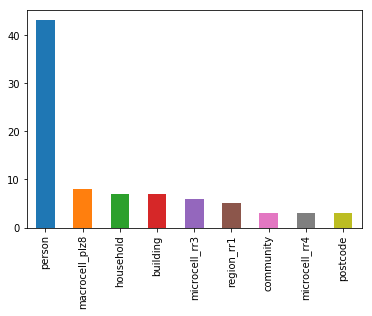

In [9]:
#Looking at the unique values in the last three rows since the 'attribute' should have a fill 85 values as an index
feat_info['information_level'].value_counts().plot(kind='bar');

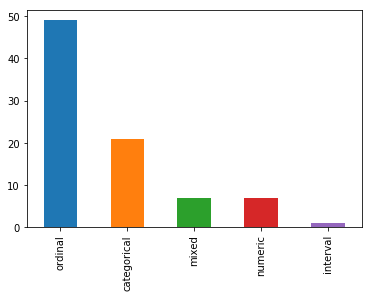

In [10]:
feat_info['type'].value_counts().plot(kind='bar');

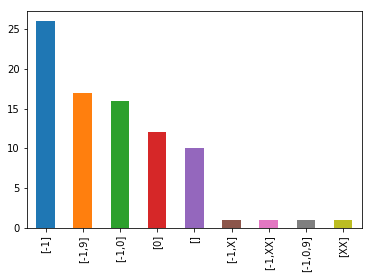

In [11]:
feat_info['missing_or_unknown'].value_counts().plot(kind='bar');

Lets begin with parsing the missing or unknown values from the feat_info summary

In [12]:
#Function that takes in any string and parses out a list if it contains any of the missing or unknown values from the 
# Feature_info 'missing_or_unknown' values. It returns a list contains -1, 0, 9, X, XX, or no entry.

def parse_string(string):
    
    partial = None     #initializer

#    print('Got string "{}", of type {}'.format(string, type(string)))

    if '-1' in string:
        partial = -int(1) 

    elif 'X' in string:
        if 'XX' in string:
            partial = 'XX' 
        else:
            partial = 'X'
        
    elif '0' in string:
        partial = int(0) 

    elif '9' in string:
        partial = int(9) 


    return partial

In [13]:
#Just testing parse_string function!
a='XX]'
print(parse_string(a))

XX


In [14]:
#Function to take in feature_summary dictinary ('feat_info' in our case) and extract the missing_unknown string 
#Output a list of the integer contents of that string
def parse_summary(summary):

    parse_list = []
    for ii, values in enumerate(summary['missing_or_unknown']):
        split_str = values.split(',')  #split string 

        partial_list = []
        for items in split_str:
            partial_list.append(parse_string(items))

#        print('Row {} - Got string "{}" & returning list of "{}"'.format(ii+2, values, partial_list)) 
        
        parse_list.append(partial_list)

    return parse_list
            

In [15]:
#Test Parsing function and subfunction are working -GOOD, able to take in missing_unknown string and produce lists.
parsed_list =[]
parsed_list = parse_summary(feat_info)
parsed_list

[[-1, 0],
 [-1, 0, 9],
 [-1, 0],
 [0],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1],
 [0],
 [None],
 [None],
 [-1, 0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [-1, 0],
 [-1, 0],
 [0],
 [-1, 9],
 [-1, 9],
 [-1, 9],
 [-1, 9],
 [-1, 9],
 [-1, 9],
 [-1, 9],
 [-1, 9],
 [-1, 9],
 [-1, 9],
 [-1, 9],
 [-1, 9],
 [-1, 9],
 [-1, 9],
 [-1],
 [-1],
 [-1, 0],
 [-1],
 [-1, 9],
 [0],
 [None],
 [None],
 [-1, 0],
 [-1],
 [-1, 0],
 [-1, 0],
 [0],
 [None],
 [-1, 0],
 [None],
 [0],
 [-1],
 [-1],
 [-1, 'X'],
 ['XX'],
 [-1, 'XX'],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1, 0],
 [-1, 0],
 [-1],
 [-1],
 [-1],
 [None],
 [-1, 0],
 [None],
 [None],
 [-1, 0],
 [None],
 [-1],
 [-1],
 [-1],
 [-1],
 [-1, 0],
 [-1],
 [-1],
 [-1, 9],
 [-1, 0],
 [-1, 9]]

In [16]:
#Function to read a dataset in and count the errors found from a missing values list and prints out findings
#Function is to replace these items with NaN placeholders and just return a list of error distribution per column.

def replace_missing(dataset, summary):
    
    m_or_u_dist = []     #list to hold the total unknowns from all columns
    col_count=0
    
    parsed_list = parse_summary(summary)
    
    
    #Now, look at each columnn in dataset and count the number of errors that are in our 'parsed_list'   
    for ii, col_name in enumerate(dataset.columns):

        col_count=0
#        print('Going to look thru parsed_list {} for missing values in column {}'.format(parsed_list[ii], col_name))
#        print('Before col_name for loop, col_count is {}'.format(col_count))
        for jj, row_item in enumerate(dataset[col_name]):

            if row_item in parsed_list[ii]:
                col_count +=1 

        #Replace all parsed missing values with NaN placeholder        
        dataset[col_name].replace(parsed_list[ii], np.nan, inplace=True)

#        print('  After col_name for loop, col_count is {}'.format(col_count))

        m_or_u_dist.append(col_count)     #Running counter of errors found per column in 'azdias' table

        print('From column #{:>2} "{:<21}" found {:>8} "missing_or_unknown" values'.format(ii+1, col_name, col_count))

        
    return m_or_u_dist



In [17]:
#Run function to print out the errors in each column of Azdias dataset that match 'unknown or missing' values
#Creates a list of the dataset columns with their respective missing (NaN) counted, which is used in later analysis  
azdias_nan_dist = replace_missing(azdias, feat_info)
print(azdias_nan_dist)

From column # 1 "AGER_TYP             " found   685843 "missing_or_unknown" values
From column # 2 "ALTERSKATEGORIE_GROB " found     2881 "missing_or_unknown" values
From column # 3 "ANREDE_KZ            " found        0 "missing_or_unknown" values
From column # 4 "CJT_GESAMTTYP        " found        0 "missing_or_unknown" values
From column # 5 "FINANZ_MINIMALIST    " found        0 "missing_or_unknown" values
From column # 6 "FINANZ_SPARER        " found        0 "missing_or_unknown" values
From column # 7 "FINANZ_VORSORGER     " found        0 "missing_or_unknown" values
From column # 8 "FINANZ_ANLEGER       " found        0 "missing_or_unknown" values
From column # 9 "FINANZ_UNAUFFAELLIGER" found        0 "missing_or_unknown" values
From column #10 "FINANZ_HAUSBAUER     " found        0 "missing_or_unknown" values
From column #11 "FINANZTYP            " found        0 "missing_or_unknown" values
From column #12 "GEBURTSJAHR          " found   392318 "missing_or_unknown" values
From

In [18]:
#Now that we done our first replacement pass swap in numpy NaN values for the summary values (ie. -1, 0, 9, X or XX)
#we can now rerun the 'isNa sum' function to get a more precise count of the total NaN's in the Azdias dataset
list(azdias.isna().sum())

[685843,
 2881,
 0,
 4854,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 392318,
 4854,
 0,
 111196,
 97632,
 94572,
 77792,
 77792,
 4854,
 4854,
 108315,
 108164,
 4854,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 111196,
 73499,
 889061,
 111196,
 0,
 310267,
 73499,
 73499,
 18348,
 584612,
 147988,
 73499,
 99611,
 97008,
 93148,
 73969,
 93148,
 93148,
 93148,
 99352,
 99352,
 99352,
 133324,
 133324,
 133324,
 133324,
 476524,
 133324,
 93740,
 93740,
 93740,
 93155,
 158064,
 133324,
 4854,
 158064,
 105800,
 116515,
 116515,
 116515,
 116515,
 116515,
 116515,
 116515,
 97375,
 97274,
 97375]

Wow, that list definitely increased from the first run we did in the earlier part of after loading the data. Let us assign this list to a variable.

In [19]:
azdias_nan_list = list(azdias.isna().sum())

Now lets do the same processing for the Udacity_customers dataset as well since we need to review both for this project.

In [20]:
#Another run function to print out the NaNs in each column of Customer dataset that match 'unknown or missing' values
#Creates a list of the dataset columns with their respective missing (NaN) counted, which is used in later analysis  
customers_nan_dist = replace_missing(customers, feat_info)
print(customers_nan_dist)

From column # 1 "AGER_TYP             " found    96738 "missing_or_unknown" values
From column # 2 "ALTERSKATEGORIE_GROB " found      240 "missing_or_unknown" values
From column # 3 "ANREDE_KZ            " found        0 "missing_or_unknown" values
From column # 4 "CJT_GESAMTTYP        " found        0 "missing_or_unknown" values
From column # 5 "FINANZ_MINIMALIST    " found        0 "missing_or_unknown" values
From column # 6 "FINANZ_SPARER        " found        0 "missing_or_unknown" values
From column # 7 "FINANZ_VORSORGER     " found        0 "missing_or_unknown" values
From column # 8 "FINANZ_ANLEGER       " found        0 "missing_or_unknown" values
From column # 9 "FINANZ_UNAUFFAELLIGER" found        0 "missing_or_unknown" values
From column #10 "FINANZ_HAUSBAUER     " found        0 "missing_or_unknown" values
From column #11 "FINANZTYP            " found        0 "missing_or_unknown" values
From column #12 "GEBURTSJAHR          " found    93024 "missing_or_unknown" values
From

In [21]:
#Again after doing our first replacement pass swapping in numpy NaN values for the summary values (ie. -1, 0, 9, X or XX)
#we can now rerun the 'isNa sum' function to get a more precise count of the total NaN's in the customer dataset
list(customers.isna().sum())

[96738,
 240,
 0,
 3213,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 93024,
 3213,
 0,
 48990,
 51053,
 50941,
 50582,
 50582,
 3213,
 3213,
 48750,
 48487,
 3213,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 48990,
 46596,
 189340,
 48990,
 0,
 68747,
 46596,
 46596,
 2968,
 111937,
 56937,
 46596,
 52377,
 52110,
 49927,
 46651,
 49927,
 49927,
 49927,
 50554,
 50554,
 50554,
 55980,
 55980,
 55980,
 55980,
 109535,
 55982,
 49959,
 49959,
 49959,
 49927,
 60064,
 55980,
 3213,
 60064,
 51281,
 52764,
 52764,
 52764,
 52764,
 52764,
 52764,
 52764,
 50499,
 50476,
 50499]

And no surprise here, we expect as saw with the other dataset that the NaN count increased from the first run we did in the earlier part of after loading the data. Let us assign this list to a variable as well and move the next section.

In [22]:
customers_nan_list = list(customers.isna().sum())

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

Performing an assessment of how much missing data there is in each column of the dataset by looking at missing (NaN) value distribution by columns.


In [23]:
#Let's print the first 20 elements of Azdias and Customers columm counter lists of numpy NaN values to confirm we have a working list
azdias_nan_list[:20]

[685843,
 2881,
 0,
 4854,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 392318,
 4854,
 0,
 111196,
 97632,
 94572,
 77792,
 77792,
 4854]

In [24]:
customers_nan_list[:20]

[96738,
 240,
 0,
 3213,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 93024,
 3213,
 0,
 48990,
 51053,
 50941,
 50582,
 50582,
 3213]

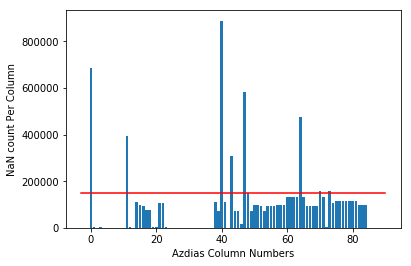

In [25]:
#Build a chart of the distribution of errors in each column. 
x = np.arange(85)
plt.bar(x, azdias_nan_list);
plt.plot([-3,90],[150000,150000], color='r')
plt.xlabel('Azdias Column Numbers')
plt.ylabel('NaN count Per Column')
plt.show()

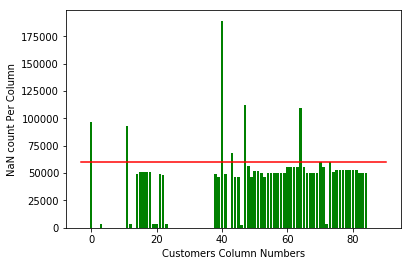

In [26]:
#Build a chart of the distribution of errors in each column. 
x = np.arange(85)
plt.bar(x, customers_nan_list, color='g');
plt.plot([-3,90],[60000,60000], color='r')
plt.xlabel('Customers Column Numbers')
plt.ylabel('NaN count Per Column')
plt.show()

Some roughly obvervations initially looking at both bar charts:
- We can see that there are similar in shape
- We can see outliers (spikes) lay in the almost the exact same columns in both charts
- They both seem to have 5-6 outlier values 
- The NaN's outliers are relative 20% of their data per column ratio (ie. 180K for Azdias and 40K for Customers dataset).

Lets get a better count of these outliers

In [27]:
#Function to print the minimum of the error_max limit
#Lets see how many Customer columns have over 60,000 (or ~20%)

def print_max_col_num(nan_list, nan_limit):
    over_limit = [i for i in nan_list if i >= nan_limit]
    print('Found a total of Azdias {} columns with errors over {}'.format(len(over_limit), nan_limit))


In [28]:
#Lets see how many Azdias columns have over 200,000 (or ~20%)
print_max_col_num(azdias_nan_list, 200000)

Found a total of Azdias 6 columns with errors over 200000


In [29]:
#Lets look at the 'azdias_nan_list' again:
sorted_nan1 = sorted(azdias_nan_list, reverse = True)
sorted_nan1[:10]

[889061,
 685843,
 584612,
 476524,
 392318,
 310267,
 158064,
 158064,
 147988,
 133324]

In [30]:
#Lets see how many Customer columns have over 60,000 (or ~20%)
print_max_col_num(customers_nan_list, 60100)

Found a total of Azdias 6 columns with errors over 60100


In [31]:
#Lets look at the 'azdias_nan_list' again:
sorted_nan2 = sorted(customers_nan_list, reverse = True)
sorted_nan2[:10]

[189340, 111937, 109535, 96738, 93024, 68747, 60064, 60064, 56937, 55982]

We can see we have roughly the same amount of outliers in almost (if not exactly) in the same positions in both bar charts

Lets investigate patterns again in the amount of missing data now labelled 'NaN' in each column.

In [32]:
#Function to make a list of how many columns have a limit of certain errors in descending order
#ie. the first element is the number of columns with 1,000,000 errors which clearly should be zero if your dataset
# is less then 1 million. The last element is the total columns in the dataset that has for a minimum of x errors.

def count_columns(errors_dist, limit):
    col_counter = 0
    for col_err in errors_dist:
        if col_err >= limit:
            col_counter += 1

    print('There are at least {:>2} columns with {:>8} NaN values.'.format(col_counter ,limit))

In [33]:
#Print the last value that represents the total columns that have at least xxx errors. 

#We will do this for Azdias dataset, with total data=900K, and step errors down by entries in err_limit list
for err_limit in list([1000000, 700000, 500000, 400000, 300000, 200000, 150000, 100000, 50000, 5000,500,50,5,1]):
    count_columns(azdias_nan_list, err_limit)

There are at least  0 columns with  1000000 NaN values.
There are at least  1 columns with   700000 NaN values.
There are at least  3 columns with   500000 NaN values.
There are at least  4 columns with   400000 NaN values.
There are at least  6 columns with   300000 NaN values.
There are at least  6 columns with   200000 NaN values.
There are at least  8 columns with   150000 NaN values.
There are at least 28 columns with   100000 NaN values.
There are at least 53 columns with    50000 NaN values.
There are at least 54 columns with     5000 NaN values.
There are at least 61 columns with      500 NaN values.
There are at least 61 columns with       50 NaN values.
There are at least 61 columns with        5 NaN values.
There are at least 61 columns with        1 NaN values.


In [34]:
#Again, but this time with the customer dataset, with total ~data=200K, and step errors down by entries in err_limit list
for err_limit in list([200000, 100000, 95000, 90000, 70000, 60000, 50000, 40000, 20000, 10000, 5000,500,50,5,1]):
    count_columns(customers_nan_list, err_limit)        

There are at least  0 columns with   200000 NaN values.
There are at least  3 columns with   100000 NaN values.
There are at least  4 columns with    95000 NaN values.
There are at least  5 columns with    90000 NaN values.
There are at least  5 columns with    70000 NaN values.
There are at least  8 columns with    60000 NaN values.
There are at least 35 columns with    50000 NaN values.
There are at least 53 columns with    40000 NaN values.
There are at least 53 columns with    20000 NaN values.
There are at least 53 columns with    10000 NaN values.
There are at least 53 columns with     5000 NaN values.
There are at least 60 columns with      500 NaN values.
There are at least 61 columns with       50 NaN values.
There are at least 61 columns with        5 NaN values.
There are at least 61 columns with        1 NaN values.


As we can see in the first analysis of the Azdias columns, the number of columns slowly increases as we look at descreasing amounts of errors that appear in the dataset. As we move from looking for the columns that have 1 million NaNs (which is obviously 0, ie. very unlikely all our data in any column is all NaN values) all the way down we see we get 6 columns with at least 200K NaN entries. And if we decrease this step value all the way down to 1 NaN value we increase that number of columns that contain at least 1 NaNs to a total of **61 columns**. What this is saying is, if you wanted to remove the columns that had at least ONE error you would have to remove a total of 61 columns from your dataset. You can see the same analysis roughtly in the Customers dataset output (ie. at 3 columns with at least 100K of Nan values) and would increase to **61 columns** as well to remove ALL NaN columns. In our case, since we have 85 columns that would be ~72% of the columns we have to work with. Clearly, this is not acceptable and we need to decide on a better NaN count per column with can feel is a balance of removing enough NaN data while at the same time leave enough columnar data to do adequate analysis for our machine learning and clustering we need to do in later sessions. Seems like our outliers should be made when we see the number of columns in this analysis jumps dramatically. As we look for both datasets **this happens at 8 columns** for the Azdias dataset (@ ~150K errors) and for the Customer dataset (@ ~60K errors). 

In [35]:
#Function to print only column and NaN count of a passed in dataset that are non-zero
def print_onlynan_col(dataset):

    for ii, col_name in enumerate(dataset.columns):

        col_count = pd.isnull(dataset[col_name]).sum()
        if col_count:
            print('Column #{:>2} "{:<22}" has {:>8} "NaN" values'.format(ii+1, col_name, col_count))
        

In [36]:
print_onlynan_col(azdias)

Column # 1 "AGER_TYP              " has   685843 "NaN" values
Column # 2 "ALTERSKATEGORIE_GROB  " has     2881 "NaN" values
Column # 4 "CJT_GESAMTTYP         " has     4854 "NaN" values
Column #12 "GEBURTSJAHR           " has   392318 "NaN" values
Column #13 "GFK_URLAUBERTYP       " has     4854 "NaN" values
Column #15 "HEALTH_TYP            " has   111196 "NaN" values
Column #16 "LP_LEBENSPHASE_FEIN   " has    97632 "NaN" values
Column #17 "LP_LEBENSPHASE_GROB   " has    94572 "NaN" values
Column #18 "LP_FAMILIE_FEIN       " has    77792 "NaN" values
Column #19 "LP_FAMILIE_GROB       " has    77792 "NaN" values
Column #20 "LP_STATUS_FEIN        " has     4854 "NaN" values
Column #21 "LP_STATUS_GROB        " has     4854 "NaN" values
Column #22 "NATIONALITAET_KZ      " has   108315 "NaN" values
Column #23 "PRAEGENDE_JUGENDJAHRE " has   108164 "NaN" values
Column #24 "RETOURTYP_BK_S        " has     4854 "NaN" values
Column #39 "SHOPPER_TYP           " has   111196 "NaN" values
Column #

In [37]:
print_onlynan_col(customers)

Column # 1 "AGER_TYP              " has    96738 "NaN" values
Column # 2 "ALTERSKATEGORIE_GROB  " has      240 "NaN" values
Column # 4 "CJT_GESAMTTYP         " has     3213 "NaN" values
Column #12 "GEBURTSJAHR           " has    93024 "NaN" values
Column #13 "GFK_URLAUBERTYP       " has     3213 "NaN" values
Column #15 "HEALTH_TYP            " has    48990 "NaN" values
Column #16 "LP_LEBENSPHASE_FEIN   " has    51053 "NaN" values
Column #17 "LP_LEBENSPHASE_GROB   " has    50941 "NaN" values
Column #18 "LP_FAMILIE_FEIN       " has    50582 "NaN" values
Column #19 "LP_FAMILIE_GROB       " has    50582 "NaN" values
Column #20 "LP_STATUS_FEIN        " has     3213 "NaN" values
Column #21 "LP_STATUS_GROB        " has     3213 "NaN" values
Column #22 "NATIONALITAET_KZ      " has    48750 "NaN" values
Column #23 "PRAEGENDE_JUGENDJAHRE " has    48487 "NaN" values
Column #24 "RETOURTYP_BK_S        " has     3213 "NaN" values
Column #39 "SHOPPER_TYP           " has    48990 "NaN" values
Column #

Just looking at the 15 of the columns we see some patterns in the Germans' feelings about providing input to surveys. I have printed out the same column NaN count for both dataset so we can see them side by side. I have grouped them based on what I think seems to be the overall theme they should belong to.

#### Age and Health columns:
    - Col  1 - AGER_TYP (685843 missing values) - Best-ager (passive or cultural elderly, experience-driven)
    - Col  1 - AGER_TYP ( 96738 missing values) - Best-ager (passive or cultural elderly, experience-driven)

    - Col 12 - GEBURTSJAHR ( 392318 missing values)  - Year of birth
    - Col 12 - GEBURTSJAHR (  93024 missing values)  - Year of birth

    - Col 15 - HEALTH_TYP ( 111196  missing values)  - Health typology
    - Col 15 - HEALTH_TYP (  48990  missing values)  - Health typology


#### Income and Family Size:
    - Col 16 - LP_LEBENSPHASE_FEIN (97632 missing values) - Life stage, fine scale
    - Col 16 - LP_LEBENSPHASE_FEIN (51053 missing values) - Life stage, fine scale

    - Col 17 - LP_LEBENSPHASE_GROB (94572 missing values) - Life stage, rough scale
    - Col 17 - LP_LEBENSPHASE_GROB (50941 missing values) - Life stage, rough scale

    - Col 18 - LP_FAMILIE_FEIN  (77792 missing values) - Family type, fine scale
    - Col 18 - LP_FAMILIE_FEIN  (50582 missing values) - Family type, fine scale

    - Col 19 - LP_FAMILIE_GROB  (77792 missing values) - Family type, rough scale
    - Col 19 - LP_FAMILIE_GROB  (50582 missing values) - Family type, rough scale

    - Col 44 - ALTER_HH   (310267 missing values) - Birthdate of head of household
    - Col 44 - ALTER_HH   ( 68747 missing values) - Birthdate of head of household

    - Col 49 - W_KEIT_KIND_HH  (147988  missing values) - Likelihood of children in household
    - Col 49 - W_KEIT_KIND_HH  ( 56937  missing values) - Likelihood of children in household

    - Col 65 - KBA05_BAUMAX ( 476524  missing values)  - building type within neighbourhood
    - Col 65 - KBA05_BAUMAX ( 109535  missing values)  - building type within neighbourhood



#### Nationality and Youth Influence:
    - Col 22 - NATIONALITAET_KZ  (108315 missing values) - Nationality based on given name analysis
    - Col 22 - NATIONALITAET_KZ  ( 48750 missing values) - Nationality based on given name analysis

    - Col 23 - PRAEGENDE_JUGENDJAHRE (108164 missing values) - Dominating movement of person's youth
    - Col 23 - PRAEGENDE_JUGENDJAHRE ( 48487 missing values) - Dominating movement of person's youth


#### Shopping Habits:
    - Col 39 - SHOPPER_TYP ( 111196 missing values) - Shopper type
    - Col 39 - SHOPPER_TYP (  48990 missing values) - Shopper type


#### Prefix Titles:
    - Col 41 - TITEL_KZ  (889061 missing values) - Academic title (Dr., Prof... etc.)
    - Col 41 - TITEL_KZ  (189340 missing values) - Academic title (Dr., Prof... etc.)

    - Col 42 - VERS_TYP  (111196 missing values) - Insurance typology (social-safety driven or accepting of risks)
    - Col 42 - VERS_TYP  ( 48990 missing values) - Insurance typology (social-safety driven or accepting of risks)




Seems like the German people are not forthcoming when it comes to providing information on their Age, Health, Inocome and Family details.

So looking at a more granular look at each columns errors we see the lowest errors is 58 (in column 84 - ORTSGR_KLS9). If we decide to remove any column with at least 58 errors we would remove a total of 25 columns.

However, that would be removing every column that contained at least ONE error, which might be removing some critical relative info. about the participates all in an effort to have a pristine dataset. Since we want to maintain as much of the original data yet have some of the major holds removed from our analysis we will decide of a clip level of 100,000 errors is an acceptable level to make a decision on to remove a column. 

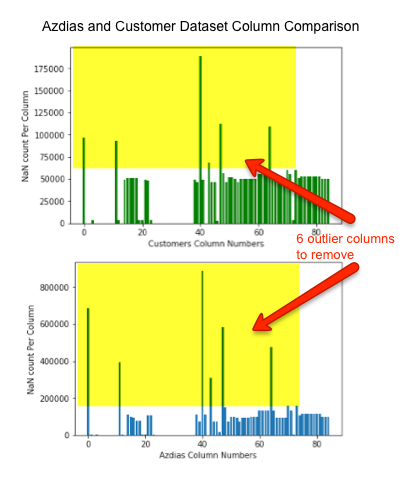

As we can see from the marked histogram chart we have about 6 in this range that I would consider the outliers, so we can drop these columns so there is reduced errors in our dataset relatively speaking with respect to the columnar view.


In [38]:
#Function to remove columns that has any errors greater then a certain acceptable limit.

def del_col_with_errors(nan_list, dataset, err_limit):
    col_list_2delete = []
    for ii, col_err in enumerate(nan_list):
        if col_err > err_limit:
            col_list_2delete.append(dataset.columns[ii])
            print('{:>7} in {:>7}'.format(col_err,dataset.columns[ii]))
            
    dataset_drop = dataset.drop(col_list_2delete, axis=1)

    return dataset_drop, col_list_2delete


 

In [39]:
azdias2, azdias_dropped_cols = del_col_with_errors(azdias_nan_list, azdias, 200000)

 685843 in AGER_TYP
 392318 in GEBURTSJAHR
 889061 in TITEL_KZ
 310267 in ALTER_HH
 584612 in KK_KUNDENTYP
 476524 in KBA05_BAUMAX


In [40]:
#Just to see what the 'dropped_cols' list contains:
azdias_dropped_cols

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [41]:
#Confirm we have dropped all 6 columns with errors, we should get 79 columens (ie. 85-6)
len(azdias2.columns)

79

In [42]:
azdias2.shape

(891221, 79)

In [43]:
customers2, cust_dropped_cols = del_col_with_errors(customers_nan_list, customers, 60100)

  96738 in AGER_TYP
  93024 in GEBURTSJAHR
 189340 in TITEL_KZ
  68747 in ALTER_HH
 111937 in KK_KUNDENTYP
 109535 in KBA05_BAUMAX


In [44]:
#And even thou not necessary but for consistency we print out the 'dropped_cols' list contains:
cust_dropped_cols

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [45]:
#Confirm we have dropped all 6 columns with errors, we should get 79 columens (ie. 85-6)
len(customers2.columns)

79

In [46]:
customers2.shape

(191652, 79)

In [47]:
len(feat_info['attribute'])

85

In [48]:
#As a cleanup task we need to remove the columns we dropped above from the 'feat_info' summary dataset
#Since the drop list for both azdias_dropped_cols = cust_dropped_cols we can use either to drop these cols
    
#First get the index of rows that match the dropped columns from the new Azdias_keep dataset
ind_todrop_from_feat = list(feat_info[feat_info.isin(azdias_dropped_cols).attribute].index)
ind_todrop_from_feat

[0, 11, 40, 43, 47, 64]

In [49]:
feat_info2 = feat_info.drop(ind_todrop_from_feat, axis = 0)

In [50]:
#Confirm we have dropped the SIX rows in feat_info from 85 down to 79
feat_info2.shape

(79, 4)

#### Discussion 1.1.2: Assess Missing Data in Each Column

As we can confirm above it seems the top SIX (6) columns with the highest count of NaN values is the exact same in both datasets. I also confirmed that that our new dataset only has 79 columns. Additional discussion points were provided above. 

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [51]:
#Lets find how much data is missing in each row of the azdias2 dataset

azdias_row_nans = azdias2.isna().sum(axis=1)
azdias_row_nans

0         43
1          0
2          0
3          7
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11        47
12         6
13         8
14        47
15         8
16         6
17        47
18         3
19         0
20        10
21         0
22         0
23         8
24        47
25         5
26        19
27         0
28         0
29         2
          ..
891191     0
891192     0
891193     0
891194     0
891195     0
891196     0
891197     0
891198     0
891199     0
891200     0
891201     0
891202     0
891203    14
891204     0
891205     0
891206     0
891207     0
891208     3
891209     0
891210     0
891211     0
891212     0
891213     0
891214     0
891215     0
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64

In [52]:
#Lets find how much data is missing in each row of the azdias2 dataset

cust_row_nans = customers2.isna().sum(axis=1)
cust_row_nans

0          0
1         45
2          0
3          7
4          0
5          0
6          0
7          0
8          2
9          0
10        34
11         0
12         0
13         6
14         0
15         0
16         0
17         0
18         0
19         0
20         6
21         0
22         0
23         0
24         0
25         0
26         0
27         0
28         0
29         0
          ..
191622     0
191623     0
191624     0
191625     0
191626     0
191627     0
191628     0
191629     0
191630     0
191631     5
191632     0
191633     0
191634     0
191635     0
191636     0
191637     0
191638     0
191639     8
191640     0
191641     0
191642     0
191643     0
191644     0
191645     0
191646     0
191647     0
191648    14
191649     0
191650     0
191651     0
Length: 191652, dtype: int64

Well that list isn't going to be much help as it is way too big! Need to find another way.

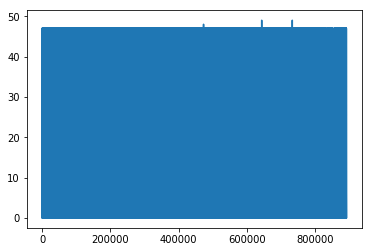

In [53]:
#Plotting this list of NaN's by row isn't very helpful as there are too many rows to fit in a graph like this:
plt.plot(azdias_row_nans);

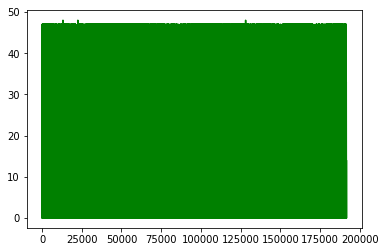

In [54]:
plt.plot(cust_row_nans, color='g');

Even thou the output is too long for analysis, we can still use it by adding as a column in our dataset and sorting the data by this new column. Lets add this to our Azdias dataset.

In [55]:
azdias2['row_nans'] = azdias2.isna().sum(axis=1)


In [56]:
customers2['row_nans'] = customers2.isna().sum(axis=1)


In [57]:
#Confirm 'row_nans' column was added, scroll to the far right!
azdias2.head(5)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,row_nans
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43
1,1.0,2,5.0,1,5,2,5,4,5,1,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,7
4,3.0,1,5.0,4,3,4,1,3,2,5,...,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0


In [58]:
#Confirm 'row_nans' column was added, scroll to the far right!
customers2.head(5)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,row_nans
0,4.0,1,5.0,5,1,5,1,2,2,2,...,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0,0
1,4.0,1,NaN,5,1,5,1,3,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45
2,4.0,2,2.0,5,1,5,1,4,4,2,...,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0,0
3,4.0,1,2.0,5,1,5,2,1,2,6,...,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0,7
4,3.0,1,6.0,3,1,4,4,5,2,2,...,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0,0


In [59]:
#Confirm we added a new column to dataset, we should have 79 + 1 = 80 columns now
azdias2.shape


(891221, 80)

In [60]:
customers2.shape


(191652, 80)

In [61]:
#Function to make a dictionary of with key as the number of NaNs per column and value of the total NaN rows counted

#So we need group the number of NaN rows by the number of NaN columns, first we need to sort the data:
def make_nan_dict(row_nans):
    
    d = {}
    for i in sorted(row_nans):
        key = i
        if i not in d:
            d[i] = []
        d[key].append(i)

    #Now, make a dictionary based the previous one summarizing the number of rows that contain that many of NaN columns

    b ={}
    for i in d:

        key = i
        if i not in b:
            b[i] = []
        b[key]=(len(d[i]))   

    return b

In [62]:
 azdias_cols_with_nans_dict = make_nan_dict(azdias_row_nans)
    

In [63]:
 cust_cols_with_nans_dict = make_nan_dict(cust_row_nans)
    

In [64]:
azdias_cols_with_nans_dict


{0: 623209,
 1: 15738,
 2: 27926,
 3: 17629,
 4: 12607,
 5: 22515,
 6: 13771,
 7: 13714,
 8: 24592,
 9: 3042,
 10: 5410,
 11: 1127,
 12: 766,
 13: 3255,
 14: 2243,
 15: 4743,
 16: 2505,
 17: 677,
 18: 428,
 19: 1180,
 20: 349,
 21: 150,
 22: 129,
 23: 132,
 24: 69,
 25: 55,
 26: 59,
 27: 24,
 28: 5,
 29: 12,
 30: 6,
 31: 3,
 32: 206,
 33: 2985,
 34: 10816,
 35: 3911,
 36: 84,
 37: 538,
 38: 421,
 39: 77,
 40: 137,
 41: 356,
 42: 21,
 43: 27369,
 44: 155,
 45: 494,
 47: 45578,
 48: 1,
 49: 2}

In [65]:
cust_cols_with_nans_dict

{0: 115643,
 1: 966,
 2: 5507,
 3: 1632,
 4: 1430,
 5: 3811,
 6: 1938,
 7: 2500,
 8: 2372,
 9: 360,
 10: 2909,
 11: 161,
 12: 195,
 13: 504,
 14: 343,
 15: 627,
 16: 328,
 17: 96,
 18: 83,
 19: 185,
 20: 50,
 21: 21,
 22: 12,
 23: 17,
 24: 11,
 25: 12,
 26: 5,
 27: 3,
 28: 1,
 29: 3,
 32: 46,
 33: 784,
 34: 1936,
 35: 291,
 36: 7,
 37: 101,
 38: 58,
 39: 7,
 40: 3,
 41: 8,
 42: 1,
 43: 5627,
 44: 52,
 45: 38,
 47: 40965,
 48: 3}

In [66]:
#So if we want to find the number of rows with ZERO (0) NaNs in any column that should be in the 1st element:
azdias_cols_with_nans_dict[0]


623209

In [67]:
cust_cols_with_nans_dict[0]


115643

What this is saying is we have 623209 rows is the Azdias and 115643 rows in the customer datasets that contain NO NaN values, which is ~70% and ~60% of their original datasets respectively. Great!

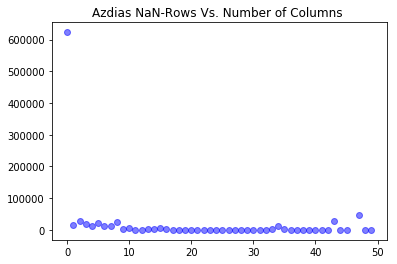

In [68]:
#Plot the distribution of the NaN rows found vs. number of columns that contain that number of NaNs

#Max. number of rows that 0 NaN entries is 115643  <-- is this dot in the upper left corner below!!!!
#Min. number of rows that 49 NaN entries is 1


plt.scatter(list(azdias_cols_with_nans_dict.keys()), azdias_cols_with_nans_dict.values(), color='b', alpha=0.5)
plt.title('Azdias NaN-Rows Vs. Number of Columns ')
plt.show()


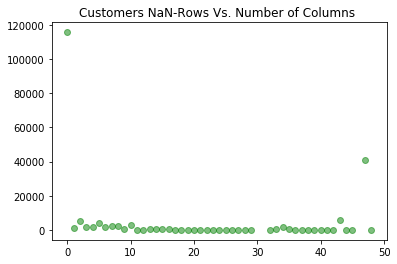

In [69]:
#Plot the distribution of the NaN rows found vs. number of columns that contain that number of NaNs
#Max. number of rows that 0 NaN entries is 623209  <-- is this dot in the upper left corner below!!!!
#Min. number of rows that 49 NaN entries is 1


plt.scatter(list(cust_cols_with_nans_dict.keys()), cust_cols_with_nans_dict.values(), color='g', alpha=0.5)
plt.title('Customers NaN-Rows Vs. Number of Columns ')
plt.show()


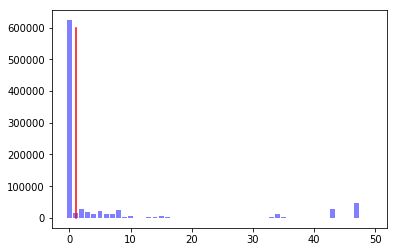

In [70]:
plt.bar(list(azdias_cols_with_nans_dict.keys()), azdias_cols_with_nans_dict.values(), color='b', alpha=0.5)
plt.plot([1,1],[-10,600000], color='r')
plt.show()


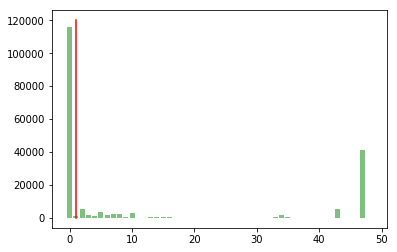

In [71]:
plt.bar(list(cust_cols_with_nans_dict.keys()), cust_cols_with_nans_dict.values(), color='g', alpha=0.5)
plt.plot([1,1],[-10,120000], color='r')
plt.show()


Lets cut out all the rows that have NaN entries and just work with a NaN free for both datasets

In [72]:
#Function to divide the data into two subsets based on the number of missing values in each row.

def divideby_nans(dataset, col_cutoff=20):
    dataset_discard = dataset[dataset['row_nans'] > col_cutoff]
    dataset_keep = dataset[dataset['row_nans'] <= col_cutoff]
    percent_discard = round(dataset_discard.shape[0]/len(dataset)*100,0)
    percent_keep = 100-percent_discard    
    print('You are discarding: {} rows or {}% of the dataset'.format(dataset_discard.shape[0],percent_discard))
    print('You are keeping: {:>8} rows or {}% of the dataset'.format(dataset_keep.shape[0],percent_keep))


    return dataset_discard, dataset_keep


In [73]:
#Test to see if decreasing the NaN cutoff point down from 20 -> 10 would decrease our data dramatically? 
azdias_discard2, azdias_keep2 = divideby_nans(azdias2, 10)


You are discarding: 111068 rows or 12.0% of the dataset
You are keeping:   780153 rows or 88.0% of the dataset


In [74]:
#Test to see if decreasing the NaN cutoff point down from 10 -> 0 would decrease our data dramatically? 
azdias_discard3, azdias_keep3 = divideby_nans(azdias2, 0)


You are discarding: 268012 rows or 30.0% of the dataset
You are keeping:   623209 rows or 70.0% of the dataset


Zero NaN rows looks like an acceptable split to use so we will do the same on the customer data

In [75]:
#Create a split of the customer dataset by specifying we will accept min. of 0 columns to contain NaN entries
customer_discard3, customer_keep3 = divideby_nans(customers2, 0)


You are discarding: 76009 rows or 40.0% of the dataset
You are keeping:   115643 rows or 60.0% of the dataset


Text(0,0.5,'NaN Row Count')

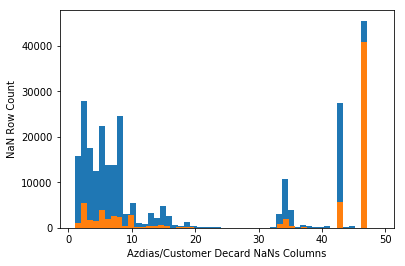

In [76]:
plt.hist(azdias_discard3['row_nans'], bins=50);
plt.hist(customer_discard3['row_nans'], bins=50);
plt.xlabel('Azdias/Customer Decard NaNs Columns')
plt.ylabel('NaN Row Count')

Text(0,0.5,'NaN Row Count')

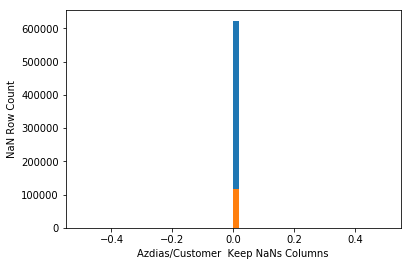

In [77]:
plt.hist(azdias_keep3['row_nans'], bins=50);
plt.hist(customer_keep3['row_nans'], bins=50);
plt.xlabel('Azdias/Customer  Keep NaNs Columns')
plt.ylabel('NaN Row Count')

In [78]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def compare_dist(data1, data2, col_name):
    fig, ax =plt.subplots(1,2)
    sns.countplot(data1[col_name], ax=ax[0])
    sns.countplot(data2[col_name], ax=ax[1])
    plt.subplots_adjust(wspace= 0.5)
    fig.show()
    return

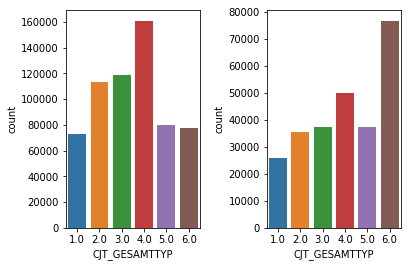

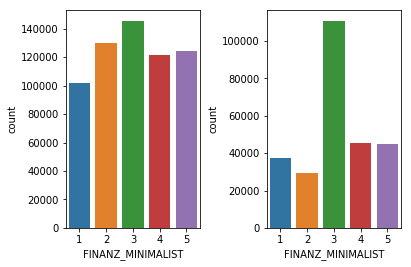

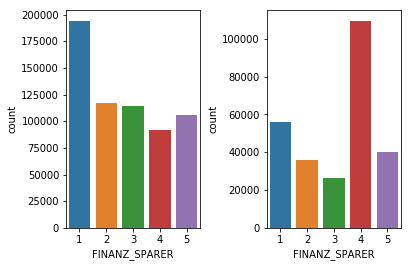

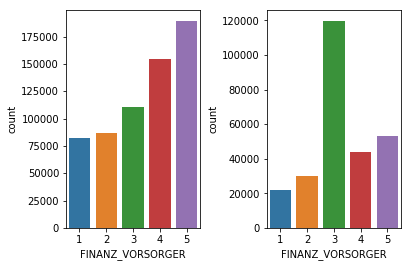

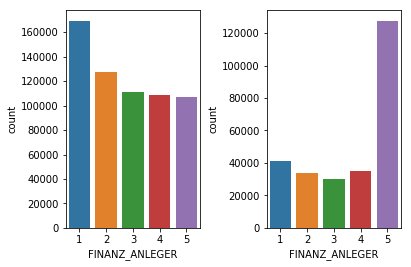

In [79]:
#Run comparison on the 5 of the columns at the '0' NaN Count split on Azdias to see any obvious difference 

for name in azdias_keep3.columns[2:7]:

    compare_dist(azdias_keep3, azdias_discard3, name)
    
    

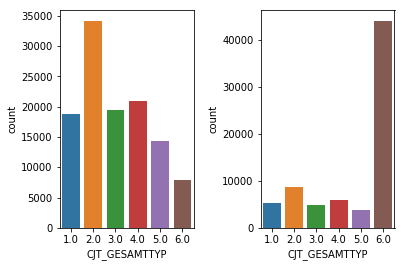

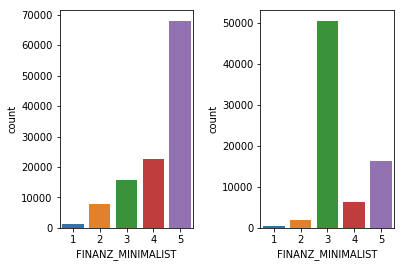

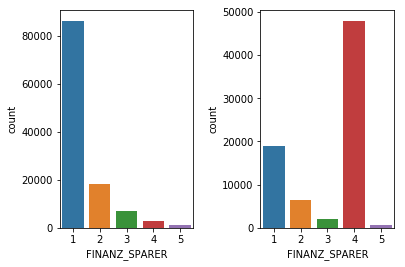

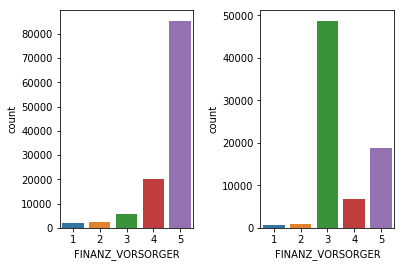

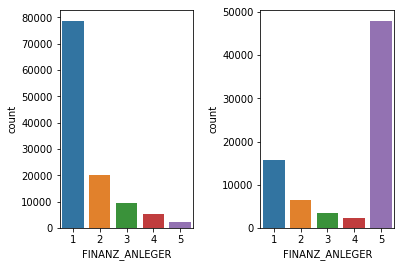

In [80]:
#Run comparison on the 5 of the columns at the '0' NaN Count split on Azdias to see any obvious difference 

for name in customer_keep3.columns[2:7]:

    compare_dist(customer_keep3, customer_discard3, name)

Now we just need to remove the NaN column and confirm we have a 'NaN free' dataset

In [81]:
azdias_keep3.shape

(623209, 80)

In [82]:
customer_keep3.shape

(115643, 80)

In [83]:
azdias_keep3 = azdias_keep3.drop('row_nans', axis=1)

In [84]:
azdias_keep3.shape

(623209, 79)

In [85]:
customer_keep3 = customer_keep3.drop('row_nans', axis=1)

In [86]:
customer_keep3.shape

(115643, 79)

In [87]:
if True not in azdias_keep3.isna():
    print('Got a clean azdias dataset NaN free!')
else:
     print('Oops! Looks like you miss a few NaNs')

Got a clean azdias dataset NaN free!


In [88]:
if True not in customer_keep3.isna():
    print('Got a clean customers dataset NaN free!')
else:
     print('Oops! Looks like you miss a few NaNs')

Got a clean customers dataset NaN free!


#### Discussion 1.1.3: Assess Missing Data in Each Row

As mentioned above, when making the split of the dataset at the 20 row_nans mark I found that about 89% of data was still contained in the lower 'kept' dataset (azdias_keep). And as just tested, if we lower that cutoff point from 20 to 10 NaN_columns we only loose ~17,000 rows or 1% of the dataset. And if we drop it all the way down from 10 to 0 we get 623209 rows that have ZERO NaN entries but the dataset set drops down to 70% with NO NaN entries.

So it seems worth while to separate the data on this new 0 NaN_column mark (ie. use  dataset 'azdias_keep3' for the next part) to guarantee the dataset with the lowest NaNs in the dataset.

Further on our analysis, the data with lots of missing values (in the 'discarded' dataset) is visually and qualitatively different from data with few or no missing values as we can see the spiky nature of the discarded half the five comparisons above. Another thing to remember, is the scale of the comparison graphs, example:

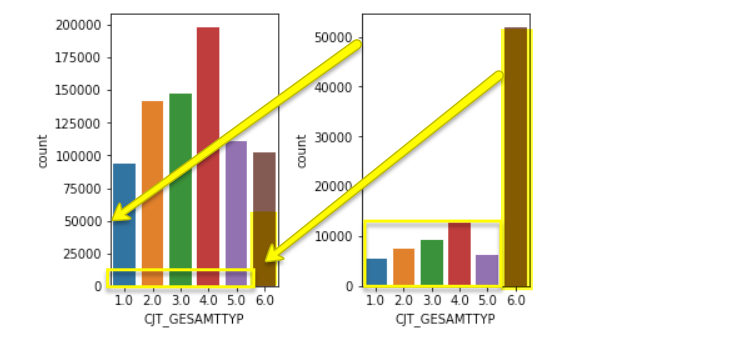

So 50000 on the 'discard' graph is only a 1/5th of 'keep' graph. So the comparison is much more dramatic then it is shown in the comparisons above.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [89]:
# How many features are there of each data type?

feat_info2.head(4)

,attribute,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [90]:
pd.value_counts(feat_info2['type'])

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [91]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

def get_list_of_type(summary_info, data_type):
    
    return summary_info[summary_info['type'] == data_type]

In [92]:
feat_info_cat = get_list_of_type(feat_info2, 'categorical')

In [93]:
feat_info_cat


,attribute,information_level,type,missing_or_unknown
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]
21,NATIONALITAET_KZ,person,categorical,"[-1,0]"


In [94]:
#Filter the summary to only show the attributes that are of type categorical. First need to isolate column.
feat_info_cat['attribute']

2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

In [95]:
#Function to pull out the matching columns that remain in our new filtered dataset that are in match_column list

def get_cat_columns(dataset, match_columns_list):
    cat_col_list = []
    for col in dataset.columns:
        if col in match_columns_list:
            cat_col_list.append(col)
            
    print(cat_col_list)
    print('This list has {} columns'.format(len(cat_col_list)))
    return cat_col_list

In [96]:
azdias_cat_col_list = get_cat_columns(azdias_keep3, list(feat_info_cat['attribute']))

['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
This list has 18 columns


In [97]:
customer_cat_col_list = get_cat_columns(customer_keep3, list(feat_info_cat['attribute']))

['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
This list has 18 columns


Now that we have a matching columns that are in both datasets from feat_info_cat, lets look at the distribution of these columns for each of the categorical data types.

In [98]:
for i in feat_info_cat['attribute']:
    if i in azdias_cat_col_list:
        print(i)

ANREDE_KZ
CJT_GESAMTTYP
FINANZTYP
GFK_URLAUBERTYP
GREEN_AVANTGARDE
LP_FAMILIE_FEIN
LP_FAMILIE_GROB
LP_STATUS_FEIN
LP_STATUS_GROB
NATIONALITAET_KZ
SHOPPER_TYP
SOHO_KZ
VERS_TYP
ZABEOTYP
GEBAEUDETYP
OST_WEST_KZ
CAMEO_DEUG_2015
CAMEO_DEU_2015


In [99]:
for i in feat_info_cat['attribute']:
    if i in customer_cat_col_list:
        print(i)

ANREDE_KZ
CJT_GESAMTTYP
FINANZTYP
GFK_URLAUBERTYP
GREEN_AVANTGARDE
LP_FAMILIE_FEIN
LP_FAMILIE_GROB
LP_STATUS_FEIN
LP_STATUS_GROB
NATIONALITAET_KZ
SHOPPER_TYP
SOHO_KZ
VERS_TYP
ZABEOTYP
GEBAEUDETYP
OST_WEST_KZ
CAMEO_DEUG_2015
CAMEO_DEU_2015


In [100]:
#Lets reminder ourselves of the number of types in Feat_info again:
pd.value_counts(feat_info2['type'])

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

So we have 18 categorical columns, lets print out these and see which ones need reencoding

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2961: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


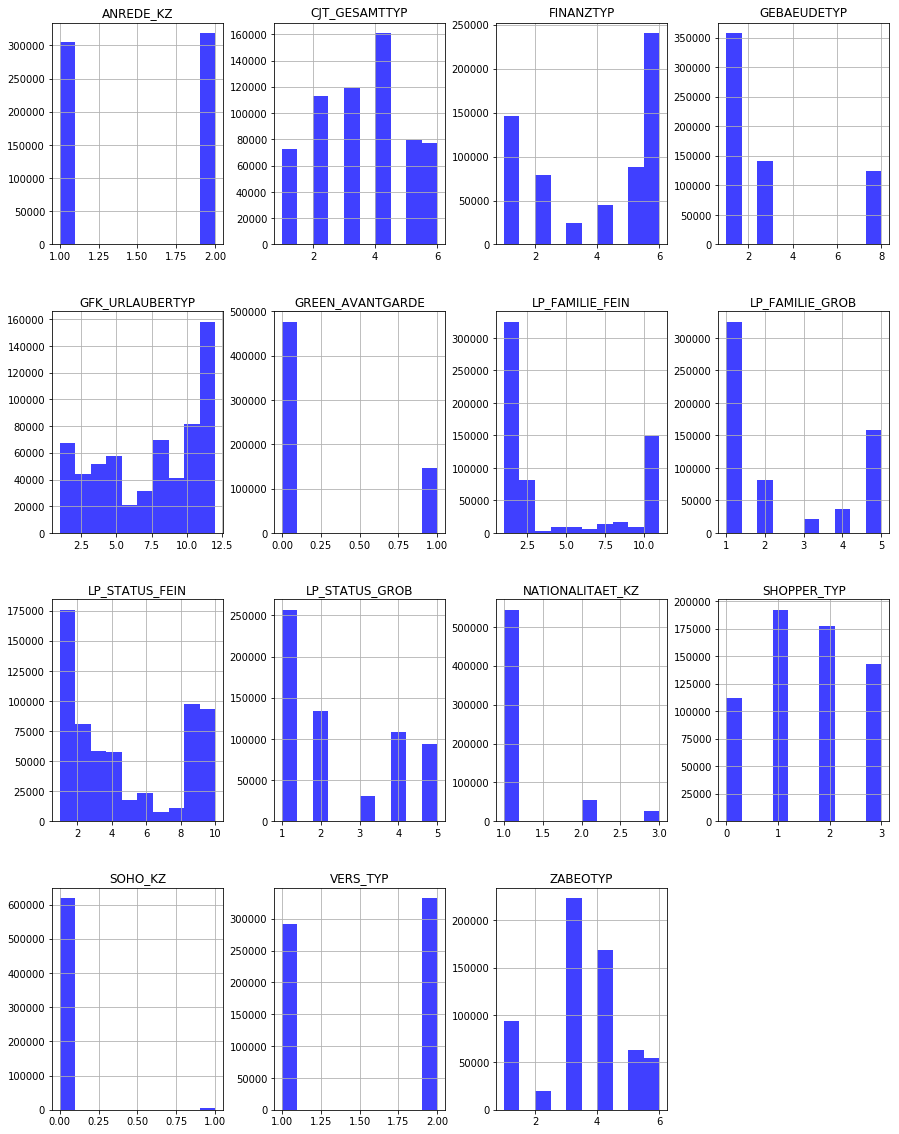

In [101]:
#Lets gragh the distribution of each for categorical azdias dataset
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
azdias_keep3[feat_info_cat['attribute']].hist(ax = ax, color='blue', alpha=0.75);

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2961: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


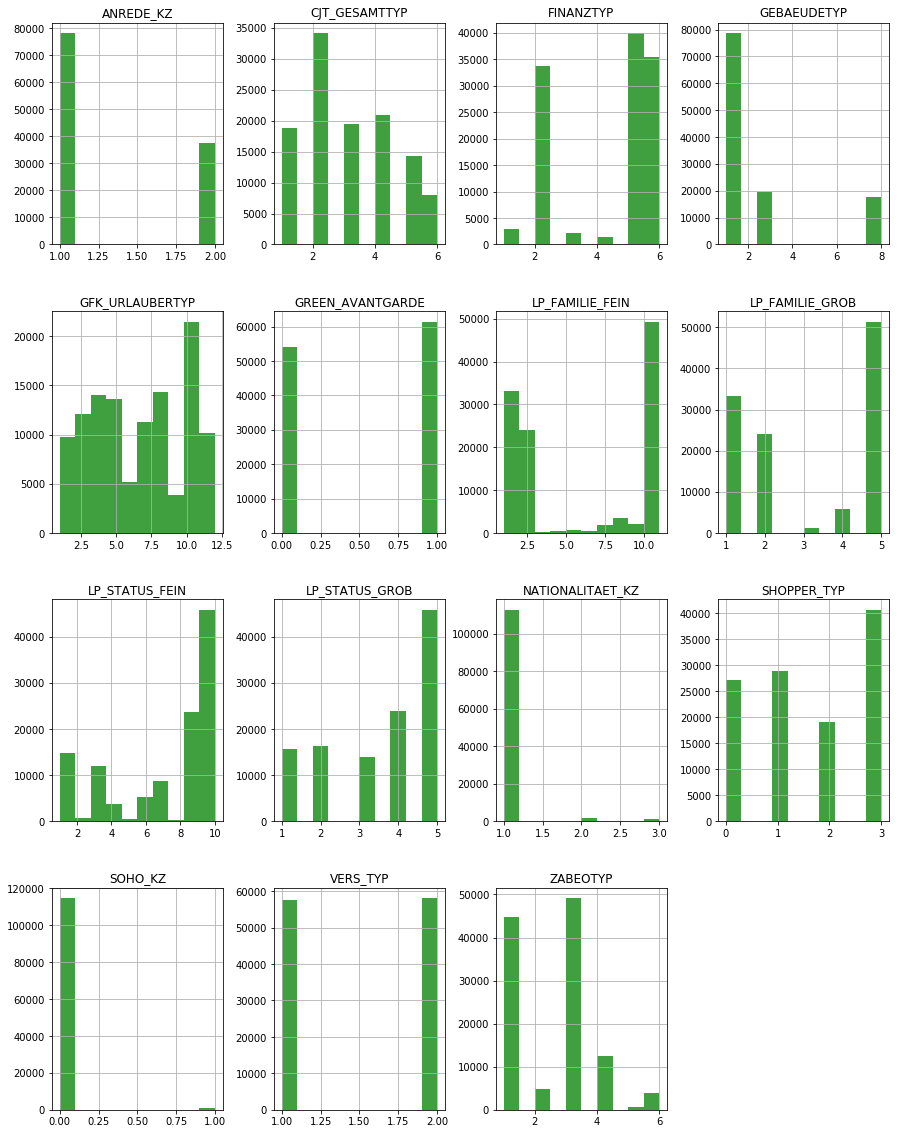

In [102]:
#Lets gragh the distribution of each for categorical in customer dataset
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
customer_keep3[feat_info_cat['attribute']].hist(ax = ax, color='green', alpha=0.75);

In [103]:
#Function to print out the unique values of each of the categorical columns 
#Returns a list of column names that need to be re-encoded, or have more then 2 categorical values
def get_recoding_list(dataset, cat_list):

    dataset.fillna(0, inplace=True)
    unq_count = 0 
    recoding_list =[]
    
    for i in cat_list:
        uniques = len(dataset[i].unique())
        
        if uniques > 2:
            recoding_list.append(i)      #add column to the list that will need to be re-encoded later 

        unq_count += uniques
        print('{:>21} : {}'.format(i, dataset[i].unique()));
        print('\n')
    print('We have a total of {} unique values to encode!'.format(unq_count))
    
    return recoding_list

In [104]:
azdias_recoding_list = get_recoding_list(azdias_keep3, azdias_cat_col_list)

            ANREDE_KZ : [2 1]


        CJT_GESAMTTYP : [ 5.  3.  2.  4.  1.  6.]


            FINANZTYP : [1 5 2 4 6 3]


      GFK_URLAUBERTYP : [ 10.   5.   1.  12.   9.   3.   8.  11.   4.   7.   6.   2.]


     GREEN_AVANTGARDE : [0 1]


      LP_FAMILIE_FEIN : [  5.   1.  10.   2.   7.  11.   8.   4.   6.   9.   3.]


      LP_FAMILIE_GROB : [ 3.  1.  5.  2.  4.]


       LP_STATUS_FEIN : [  2.   3.   4.   1.  10.   9.   5.   6.   7.   8.]


       LP_STATUS_GROB : [ 1.  2.  5.  4.  3.]


     NATIONALITAET_KZ : [ 1.  2.  3.]


          SHOPPER_TYP : [ 3.  2.  0.  1.]


              SOHO_KZ : [ 1.  0.]


             VERS_TYP : [ 2.  1.]


             ZABEOTYP : [5 4 1 6 3 2]


          GEBAEUDETYP : [ 8.  1.  3.  5.]


          OST_WEST_KZ : ['W' 'O']


      CAMEO_DEUG_2015 : ['8' '4' '6' '2' '1' '9' '5' '7' '3']


       CAMEO_DEU_2015 : ['8A' '4C' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5D' '9E' '9B' '1B' '8B' '7A'
 '3D' '4E' '3C' '5A' '7B' '9A' '6E' '6D' '2C' '5C' '9C' '7D

In [105]:
#And same thing for the customer dataset:
customer_recoding_list = get_recoding_list(customer_keep3, customer_cat_col_list)

            ANREDE_KZ : [1 2]


        CJT_GESAMTTYP : [ 5.  2.  6.  4.  3.  1.]


            FINANZTYP : [2 5 6 3 1 4]


      GFK_URLAUBERTYP : [  4.   3.   2.  11.  10.   8.   1.   5.   9.  12.   7.   6.]


     GREEN_AVANTGARDE : [1 0]


      LP_FAMILIE_FEIN : [  2.   1.  10.   8.  11.   9.   6.   5.   3.   7.   4.]


      LP_FAMILIE_GROB : [ 2.  1.  5.  4.  3.]


       LP_STATUS_FEIN : [ 10.   1.   7.   9.   6.   3.   8.   4.   2.   5.]


       LP_STATUS_GROB : [ 5.  1.  3.  4.  2.]


     NATIONALITAET_KZ : [ 1.  2.  3.]


          SHOPPER_TYP : [ 3.  1.  0.  2.]


              SOHO_KZ : [ 0.  1.]


             VERS_TYP : [ 1.  2.]


             ZABEOTYP : [3 1 2 4 6 5]


          GEBAEUDETYP : [ 1.  8.  3.]


          OST_WEST_KZ : ['W' 'O']


      CAMEO_DEUG_2015 : ['1' '5' '7' '3' '2' '4' '9' '8' '6']


       CAMEO_DEU_2015 : ['1A' '5D' '7B' '3B' '1D' '2D' '4A' '9D' '8B' '4C' '6B' '9C' '5C' '4E' '6C'
 '8C' '8A' '5B' '9B' '3D' '3C' '5F' '2A' '1E' '7C' '2C' '5A' '2

We can see at least THREE of the columns above (OST_WEST_KZ, CAMEO_DEUG_2015, CAMEO_DEU_2015) have non-numeric values that need to be converted to numericals. Since OST_WEST_KZ (with two letter values 'O' and 'W') didn't make it into our re-encode list we should add that in. We will need to use OneHot encoding on these which will expand our dataset dramatically.

In [106]:
azdias_keep3['OST_WEST_KZ'].unique()

array(['W', 'O'], dtype=object)

In [107]:
customer_keep3['OST_WEST_KZ'].unique()

array(['W', 'O'], dtype=object)

In [108]:
#Even thou this column needs recoding we can wait to do one-hot encoding to 0 and 1 later on.
azdias_recoding_list.append('OST_WEST_KZ')

In [109]:
#Same thing for this customer column needs recoding we can wait to do one-hot encoding to 0 and 1 later on.
customer_recoding_list.append('OST_WEST_KZ')

In [110]:
# Re-encode categorical variable(s) to be kept in the azdias dataset analysis.
print(len(azdias_recoding_list))
print(azdias_recoding_list)

14
['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'OST_WEST_KZ']


In [111]:
# Re-encode categorical variable(s) to be kept in the customer dataset analysis.
print(len(customer_recoding_list))
print(customer_recoding_list)

14
['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'OST_WEST_KZ']


In [112]:
azdias_keep3.head(4)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


In [113]:
#Confirm the column has been dropped
azdias_keep3.shape

(623209, 79)

In [114]:
azdias_recoded = pd.get_dummies(azdias_keep3, columns=azdias_recoding_list)



In [115]:
#The column length of our new dataset after re-encoding is:
len(azdias_recoded.columns)



192

In [116]:
azdias_recoded.shape


(623209, 192)

In [117]:
#Take a look at the columns in the new dataset now...wow!!
list(azdias_recoded.columns)

['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'GREEN_AVANTGARDE',
 'HEALTH_TYP',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'RETOURTYP_BK_S',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'SOHO_KZ',
 'VERS_TYP',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'HH_EINKOMMEN_SCORE',
 'W_KEIT_KIND_HH',
 'WOHNDAUER_2008',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'KONSUMNAEHE',
 'MIN_GEBAEUDEJAHR',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_GBZ',
 'BALLRAUM',
 'EWDICHTE',
 'INNENSTADT',
 'GEBAEUDETYP_RASTER',
 'KKK',
 'MOBI_REGIO',
 'ONLINE_AFFINITAET',
 'REGIOTYP',
 'KBA13_ANZAHL_PKW',
 'PLZ8_ANTG1',
 'PLZ8_ANTG2',
 'PLZ8_ANTG3',
 'PL

Now redo for re-coding steps for the customer dataset

In [118]:
customer_keep3.head(4)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,4.0,1,5.0,5,1,5,1,2,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
2,4.0,2,2.0,5,1,5,1,4,4,2,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
4,3.0,1,6.0,3,1,4,4,5,2,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0
5,3.0,1,4.0,5,1,5,1,2,3,5,...,2.0,3.0,2.0,1.0,1.0,5.0,5.0,3.0,7.0,5.0


In [119]:
#Confirm the column has been dropped
customer_keep3.shape


(115643, 79)

In [120]:
customer_recoded = pd.get_dummies(customer_keep3, columns=customer_recoding_list)



In [121]:
#The column length of our new dataset after re-encoding is:
len(customer_recoded.columns)

191

In [122]:
#Take a look at the columns in the new dataset now...wow!!
list(customer_recoded.columns)

['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'GREEN_AVANTGARDE',
 'HEALTH_TYP',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'RETOURTYP_BK_S',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'SOHO_KZ',
 'VERS_TYP',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'HH_EINKOMMEN_SCORE',
 'W_KEIT_KIND_HH',
 'WOHNDAUER_2008',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'KONSUMNAEHE',
 'MIN_GEBAEUDEJAHR',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_GBZ',
 'BALLRAUM',
 'EWDICHTE',
 'INNENSTADT',
 'GEBAEUDETYP_RASTER',
 'KKK',
 'MOBI_REGIO',
 'ONLINE_AFFINITAET',
 'REGIOTYP',
 'KBA13_ANZAHL_PKW',
 'PLZ8_ANTG1',
 'PLZ8_ANTG2',
 'PLZ8_ANTG3',
 'PL

In [123]:
#Seems like we have one column list in the customer re-encoded list. Let's find out which one it is:

for col in azdias_recoded.columns:
    if col not in customer_recoded.columns:
        print(col)

GEBAEUDETYP_5.0


Okay, so this makes sense since '_ 5.0' came from the get dummies encoding and the original didn't have value=5.0, but might be best not to proceed with two data sets having different sizes. Lets find the location of this column in Azdias_recoded dataset and insert a 'zero' value column in the Customer_recoded. When looking at the two lists above, it seems like this column ('GEBAEUDETYP_5.0') fits right between GEBAEUDETYP_3.0 and GEBAEUDETYP_8.0 in the Azdias dataset. 

- Azdias_recoded sub-section:
 - 'GEBAEUDETYP_1.0',
 - 'GEBAEUDETYP_3.0',
 - 'GEBAEUDETYP_5.0',  <-- find this location and insert in the other
 - 'GEBAEUDETYP_8.0',


Lets see what is the location of this column so we can add it back in the Customer_recoded dataset so we can make them the same shape for all further analysis

In [124]:
azdias_recoded.columns.get_loc('GEBAEUDETYP_5.0')



135

In [125]:
#Get location from Customers to confirm exact column index to insert 'GEBAEUDETYP_5.0'
customer_recoded.columns.get_values()[134]



'GEBAEUDETYP_3.0'

In [126]:
customer_recoded.columns.get_values()[135]



'GEBAEUDETYP_8.0'

#Test first on a clone of customer_recoded dataset just incase we need to backtrack

customer_recoded2 = customer_recoded
customer_recoded2.shape



In [127]:
customer_recoded.insert(loc=135, column='GEBAEUDETYP_5.0', value=0)


In [128]:
customer_recoded.shape

(115643, 192)

In [129]:
#Confirm the  column was added to the customer_recoded data at the exact location column #135:
customer_recoded.columns.get_values()[135]


'GEBAEUDETYP_5.0'

So lets confirm OneHot Encoding was done specificially for two old columns 'OST_WEST_KZ' and 'CAMEO_DEU_2015'

In [130]:
azdias_recoded['OST_WEST_KZ_O'].unique()

array([0, 1], dtype=uint64)

In [131]:
customer_recoded['OST_WEST_KZ_O'].unique()

array([0, 1], dtype=uint64)

In [132]:
azdias_recoded['OST_WEST_KZ_W'].unique()

array([1, 0], dtype=uint64)

In [133]:
customer_recoded['OST_WEST_KZ_W'].unique()

array([1, 0], dtype=uint64)

In [134]:
azdias_recoded['CAMEO_DEU_2015_1A'].unique()

array([0, 1], dtype=uint64)

In [135]:
customer_recoded['CAMEO_DEU_2015_1A'].unique()

array([1, 0], dtype=uint64)

#### Discussion 1.2.1: Re-Encode Categorical Features

Here we are reporting our findings and decisions regarding categorical features. Assessing the data types for each column in the dataset we found we have 18 that are of 'Categorical' in nature. Out of those 18 only 4 columns had uniques values of only 2 ('ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ' and 'OST_WEST_KZ') so since re-encoding makes sense only when the uniqueness count is greater then 2 we didn't add that to your list to re-encode. There was however, one of the four that was not numerical which was 'OST_WEST_KZ' we could have decided to first encode their two unique values ('O' and 'W') to (1 and 0) but since the one-hot get-dummies encoding will take care of this we just manually added it to the re-encoding list to give us a total of 15 columns to re-code. After get-dummies function is run we get a new dataset of 192 & 191 columns for the Adzias and Customer datasets respectively. I decided it might be wise to make sure both datasets kept the same shape, so I found that column 'GEBAEUDETYP_5.0' was missing out of the Customer_recoded dataset and inserted a 'zero' column. This way, it would allow any further analysis, whether it be clustering, PCA or future cleaning modules to be reused if they had any dimensional dependancies.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [136]:
#First let us filter a list of the list of columns containing 'mixed' features:

feat_info_mix = feat_info2[feat_info2['type'] == 'mixed']
feat_info_mix

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [137]:
#Next lets get the unique values from the columns in the 'attribute' list above for Azdias dataset
feat_mix_col = list(feat_info_mix['attribute'].values)
for i in feat_mix_col:
    print(i)
    print(azdias_recoded[i].unique())
    print('\n')

LP_LEBENSPHASE_FEIN
[ 21.   3.  32.   8.   2.   5.  10.   4.   6.  20.   1.  25.  18.  31.  38.
  30.   7.  22.  14.  35.  29.  24.  37.  12.  39.  36.  13.   9.  34.  26.
  33.  15.  11.  40.  16.  19.  23.  27.  28.  17.]


LP_LEBENSPHASE_GROB
[  6.   1.  10.   2.   3.   5.   7.  12.   9.   4.  11.   8.]


PRAEGENDE_JUGENDJAHRE
[ 14.  15.   8.   3.  10.  11.   9.   5.   4.   2.   6.   1.  12.  13.   7.]


WOHNLAGE
[ 4.  2.  3.  7.  5.  1.  8.  0.]


CAMEO_INTL_2015
['51' '24' '43' '54' '22' '14' '13' '15' '34' '55' '41' '25' '31' '52' '45'
 '35' '33' '44' '32' '23' '12']


PLZ8_BAUMAX
[ 1.  2.  4.  5.  3.]




In [138]:
#Next lets do the same and get the unique values from the columns in the 'attribute' list above for Customer dataset
feat_mix_col = list(feat_info_mix['attribute'].values)
for i in feat_mix_col:
    print(i)
    print(customer_recoded[i].unique())
    print('\n')

LP_LEBENSPHASE_FEIN
[ 20.  13.  31.  17.  28.  27.   6.  40.  35.   2.  19.   5.  38.  36.   8.
  34.  10.  12.  26.  11.   9.  37.  14.  39.   7.  15.  32.  23.  21.  25.
  33.  16.  30.  18.   4.  22.   1.  29.  24.   3.]


LP_LEBENSPHASE_GROB
[  5.   3.  10.   8.   2.  12.  11.   1.   4.   6.   7.   9.]


PRAEGENDE_JUGENDJAHRE
[  4.   8.   9.   1.   6.  15.  14.   5.   3.  11.   2.  10.  13.  12.   7.]


WOHNLAGE
[ 7.  2.  3.  1.  5.  4.  8.]


CAMEO_INTL_2015
['13' '34' '41' '23' '15' '14' '22' '51' '24' '43' '33' '25' '44' '54' '32'
 '35' '12' '31' '45' '52' '55']


PLZ8_BAUMAX
[ 1.  3.  2.  5.  4.]




This is almost the exact same in both datasets. This helps as we can use the same recoding process for both.

So using the Dictionary Summary we can make the following observations:

Column LP_LEBENSPHASE_FEIN (Life stage, fine scale) has 40 values with mixture of income, marital status, life stage and family details. I think it would be almost impossible to split these codes into distinct columns without having many NaN's populate the table. As such, I will leave this as is and allow the normal encoding to take place as these 40 values do give some insight to the individual and will can be reference if further investigate on insights is needed. Therefore, keeping column and will do one-hot encoding. (KEEP!)

Column LP_LEBENSPHASE_GROB (Life stage,rough scale) almost the same description here as previous column but on a rougher scope. Still describing mixture of income, marital status, life stage and family details but instead using only 12 values instead of 40. I will decide to drop this column as it seems duplicate info found in the 'fine scale. (DROP!)

PRAEGENDE_JUGENDJAHRE (Dominating movement of person's youth) has 15 that describe details of the individuals youth influence - will keep this column and do split and re-encode the parts to capture this info. (KEEP!)

WOHNLAGE (Neighborhood quality (or rural flag) has 8 values that describe a mix of either the economic status of the individuals neighbourhood and building in a rural setting. Due the values mix this field with different insights to the indvidual I dont' think it will play much of a role in any analysis and further investigation on PCA, it might be the best choice because of the challenge to find a suitable way to represent distances between variable categories and individuals in the factorial space. Conclusion is to drop this column. (DROP!)

CAMEO_INTL_2015 (Wealth / Life Stage Typology, mapped to international code) 25 values that describe mix details of individuals stage of life and economic status. I will keep this column and do split and re-encode the parts to capture this info. See below. (KEEP!)

PLZ8_BAUMAX (Common building type within the PLZ8 region) 5 values that capture types of family or business building within the certain region. Here this data seems to be captured with several 'surrounding' four columns (ie. PLZ8_ANTG1 all the way to PLZ8_ANTG4 as well as PLZ8_HHZ and PLZ8_GBZ. Since this info seems redundant as well I will drop this column.  (DROP!)

Based on the decisions above we need to edit our Azdias to drop columns ' LP_LEBENSPHASE_GROB', 'WOHNLAGE', and 'PLZ8_BAUMAX'

In [139]:
azdias_recoded = azdias_recoded.drop(['LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX'], axis=1)

In [140]:
azdias_recoded.shape

(623209, 189)

And we will do the samething and edit our customer data to drop columns ' LP_LEBENSPHASE_GROB', 'WOHNLAGE', and 'PLZ8_BAUMAX'

In [141]:
customer_recoded = customer_recoded.drop(['LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX'], axis=1)

In [142]:
customer_recoded.shape

(115643, 189)

In [143]:
# Now, lets investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

feat_info2[feat_info2['type'] == 'mixed']

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [144]:
azdias_recoded["PRAEGENDE_JUGENDJAHRE"].unique()



array([ 14.,  15.,   8.,   3.,  10.,  11.,   9.,   5.,   4.,   2.,   6.,
         1.,  12.,  13.,   7.])

So the entries in the "PRAEGENDE_JUGENDJAHRE" column map to the following dictionary values:

Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)

-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

What we need to do is read in every entry and parse it into 3 separate values into their own column.

In [145]:
#Dictionary definitions to hold the values of parsed entries from column "PRAEGENDE_JUGENDJAHRE"

#We will map a list of 3 numbers, each for the following:
#
# Column 1 - YR: 
#    1:1 - 40s - war years, 
#    2:1 - 40s - reconstruction years,
#    3:2 - 50s - economic miracle
#    4:2 - 50s - milk bar / Individualisation
#    5:3 - 60s - economic miracle
#    6:3 - 60s - generation 68 / student protestors
#    7:3 - 60s - opponents to the building of the Wall
#    8:4 - 70s - family orientation
#    9:4 - 70s - peace movement
#    10:5 - 80s - Generation Golf
#    11:5 - 80s - ecological awareness
#    12:5 - 80s - FDJ / communist party youth organisation
#    13:5 - 80s - Swords into ploughshares
#    14:6 - 90s - digital media kids
#    15:6 - 90s - ecological awareness
#    
# Column 2 - MA:
#    01 - Mainstream
#    02 - Avantgarde
#        
# Column 3 - EW:
#    01 - E or East
#    02 - W or West
#    03 - E+W or East & West
        
PRAEGENDE_YR_dict = {0:0, 1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6 }             
PRAEGENDE_MA_dict = {0:0, 1:1, 2:2, 3:1, 4:2, 5:1, 6:2, 7:2, 8:1, 9:2, 10:1, 11:2, 12:1, 13:2, 14:1, 15:2 }
PRAEGENDE_EW_dict = {0:0, 1:3, 2:3, 3:3, 4:3, 5:3, 6:2, 7:1, 8:3, 9:3, 10:2, 11:2, 12:1, 13:1, 14:3, 15:3 }


In [146]:
#First clone three new columns into the end of the dataset:

azdias_recoded["PRAE_JUGENDJAHRE_YR"] = azdias_recoded["PRAEGENDE_JUGENDJAHRE"]
azdias_recoded["PRAE_JUGENDJAHRE_MA"] = azdias_recoded["PRAEGENDE_JUGENDJAHRE"]
azdias_recoded["PRAE_JUGENDJAHRE_EW"] = azdias_recoded["PRAEGENDE_JUGENDJAHRE"]

In [147]:
azdias_recoded.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_O,OST_WEST_KZ_W,PRAE_JUGENDJAHRE_YR,PRAE_JUGENDJAHRE_MA,PRAE_JUGENDJAHRE_EW
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,0,1,14.0,14.0,14.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,1,15.0,15.0,15.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,1,8.0,8.0,8.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,0,0,1,3.0,3.0,3.0
6,2.0,2,1,5,1,5,4,3,0,2.0,...,0,0,0,0,0,0,1,10.0,10.0,10.0


In [148]:
#Use the above dictionaries to map and replace the old column values:

azdias_recoded["PRAE_JUGENDJAHRE_YR"] = azdias_recoded["PRAEGENDE_JUGENDJAHRE"].replace(PRAEGENDE_YR_dict)
azdias_recoded["PRAE_JUGENDJAHRE_MA"] = azdias_recoded["PRAEGENDE_JUGENDJAHRE"].replace(PRAEGENDE_MA_dict)
azdias_recoded["PRAE_JUGENDJAHRE_EW"] = azdias_recoded["PRAEGENDE_JUGENDJAHRE"].replace(PRAEGENDE_EW_dict)

In [149]:
azdias_recoded.head(20)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_O,OST_WEST_KZ_W,PRAE_JUGENDJAHRE_YR,PRAE_JUGENDJAHRE_MA,PRAE_JUGENDJAHRE_EW
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,0,1,6.0,1.0,3.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,1,6.0,2.0,3.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,1,4.0,1.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,0,0,1,2.0,1.0,3.0
6,2.0,2,1,5,1,5,4,3,0,2.0,...,0,0,0,0,0,0,1,5.0,1.0,2.0
7,1.0,1,3,3,4,1,3,2,0,1.0,...,0,0,0,0,0,0,1,4.0,1.0,3.0
8,3.0,1,4,4,2,4,2,2,1,3.0,...,0,0,0,0,0,0,1,5.0,2.0,2.0
9,3.0,2,2,4,2,3,5,4,1,2.0,...,0,0,0,0,0,0,1,6.0,2.0,3.0
10,3.0,2,2,2,5,3,1,5,0,2.0,...,0,0,0,1,0,0,1,2.0,1.0,3.0
19,3.0,1,5,2,3,1,3,1,1,3.0,...,0,0,0,0,0,0,1,4.0,2.0,3.0


In [150]:
#And will do the same for the Customer dataset. 
#First clone three new columns into the end of the dataset:

customer_recoded["PRAE_JUGENDJAHRE_YR"] = customer_recoded["PRAEGENDE_JUGENDJAHRE"]
customer_recoded["PRAE_JUGENDJAHRE_MA"] = customer_recoded["PRAEGENDE_JUGENDJAHRE"]
customer_recoded["PRAE_JUGENDJAHRE_EW"] = customer_recoded["PRAEGENDE_JUGENDJAHRE"]

In [151]:
customer_recoded.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_O,OST_WEST_KZ_W,PRAE_JUGENDJAHRE_YR,PRAE_JUGENDJAHRE_MA,PRAE_JUGENDJAHRE_EW
0,4.0,1,5,1,5,1,2,2,1,1.0,...,0,0,0,0,0,0,1,4.0,4.0,4.0
2,4.0,2,5,1,5,1,4,4,1,2.0,...,0,0,0,0,0,0,1,4.0,4.0,4.0
4,3.0,1,3,1,4,4,5,2,0,3.0,...,0,0,0,0,0,0,1,8.0,8.0,8.0
5,3.0,1,5,1,5,1,2,3,1,3.0,...,0,0,0,0,0,0,1,4.0,4.0,4.0
6,4.0,1,5,1,5,1,1,2,1,2.0,...,0,0,0,0,0,0,1,4.0,4.0,4.0


In [152]:
#Use the above dictionaries to map and replace the old column values:

customer_recoded["PRAE_JUGENDJAHRE_YR"] = customer_recoded["PRAEGENDE_JUGENDJAHRE"].replace(PRAEGENDE_YR_dict)
customer_recoded["PRAE_JUGENDJAHRE_MA"] = customer_recoded["PRAEGENDE_JUGENDJAHRE"].replace(PRAEGENDE_MA_dict)
customer_recoded["PRAE_JUGENDJAHRE_EW"] = customer_recoded["PRAEGENDE_JUGENDJAHRE"].replace(PRAEGENDE_EW_dict)

In [153]:
customer_recoded.head(20)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_O,OST_WEST_KZ_W,PRAE_JUGENDJAHRE_YR,PRAE_JUGENDJAHRE_MA,PRAE_JUGENDJAHRE_EW
0,4.0,1,5,1,5,1,2,2,1,1.0,...,0,0,0,0,0,0,1,2.0,2.0,3.0
2,4.0,2,5,1,5,1,4,4,1,2.0,...,0,0,0,0,0,0,1,2.0,2.0,3.0
4,3.0,1,3,1,4,4,5,2,0,3.0,...,0,0,0,0,0,0,1,4.0,1.0,3.0
5,3.0,1,5,1,5,1,2,3,1,3.0,...,0,0,0,0,0,0,1,2.0,2.0,3.0
6,4.0,1,5,1,5,1,1,2,1,2.0,...,0,0,0,0,0,0,1,2.0,2.0,3.0
7,4.0,1,5,1,5,1,2,2,1,1.0,...,0,0,0,0,0,0,1,2.0,2.0,3.0
9,3.0,1,5,2,4,1,3,1,1,3.0,...,0,0,0,0,0,0,1,4.0,2.0,3.0
11,4.0,1,5,1,5,1,3,2,1,1.0,...,0,0,0,0,0,0,1,2.0,2.0,3.0
12,4.0,1,5,2,4,3,2,1,0,2.0,...,0,0,0,0,0,0,1,4.0,1.0,3.0
14,4.0,2,3,1,5,1,2,5,0,2.0,...,0,0,0,1,0,0,1,1.0,1.0,3.0


In [154]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

feat_info2[feat_info2['type'] == 'mixed']

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [155]:
azdias_recoded['CAMEO_INTL_2015'].unique()

array(['51', '24', '43', '54', '22', '14', '13', '15', '34', '55', '41',
       '25', '31', '52', '45', '35', '33', '44', '32', '23', '12'], dtype=object)

In [156]:
#Dictionary definitions to hold the values of parsed entries from column "CAMEO_INTL_2015"

#We will map a list of 2 numbers, each for the following:
#
# Column 1 - HH: 

#    11-15: 1   Wealthy Households
#    21-25: 2   Prosperous Households
#    31-35: 3   Comfortable Households
#    41-45: 4   Less Affluent Households
#    51-55: 5   Poorer Households
#    
# Column 2 - LS:
#    11: 1  Pre-Family Couples & Singles
#    12: 2  Young Couples With Children
#    13: 3  Families With School Age Children
#    14: 4  Older Families &  Mature Couples
#    15: 5  Elders In Retirement
#    21: 1  Pre-Family Couples & Singles
#    22: 2  Young Couples With Children
#    23: 3  Families With School Age Children
#    24: 4  Older Families &  Mature Couples
#    25: 5  Elders In Retirement
#    31: 1  Pre-Family Couples & Singles
#    32: 2  Young Couples With Children
#    33: 3  Families With School Age Children
#    34: 4  Older Families &  Mature Couples
#    35: 5  Elders In Retirement
#    41: 1  Pre-Family Couples & Singles
#    42: 2  Young Couples With Children
#    43: 3  Families With School Age Children
#    44: 4  Older Families &  Mature Couples
#    45: 5  Elders In Retirement
#    51: 1  Pre-Family Couples & Singles
#    52: 2  Young Couples With Children
#    53: 3  Families With School Age Children
#    54: 4  Older Families &  Mature Couples
#    55: 5  Elders In Retirement

        
CAMEO_INTL_2015_HH_dict = { '11':1, '12':1, '13':1, '14':1, '15':1, 
                            '21':2, '22':2, '23':2, '24':2, '25':2,
                            '31':3, '32':3, '33':3, '34':3, '35':3,
                            '41':4, '42':4, '43':4, '44':4, '45':4,
                            '51':5, '52':5, '53':5, '54':5, '55':5   }
                   
CAMEO_INTL_2015_LS_dict = { '11':1, '12':2, '13':3, '14':4, '15':5, 
                            '21':1, '22':2, '23':3, '24':4, '25':5,
                            '31':1, '32':2, '33':3, '34':4, '35':5,
                            '41':1, '42':2, '43':3, '44':4, '45':5,
                            '51':1, '52':2, '53':3, '54':4, '55':5   }


In [157]:
#First clone two new columns into the end of the dataset:

azdias_recoded["CAMEO_INTL_2015_HH"] = azdias_recoded["CAMEO_INTL_2015"]
azdias_recoded["CAMEO_INTL_2015_LS"] = azdias_recoded["CAMEO_INTL_2015"]

In [158]:
azdias_recoded.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_O,OST_WEST_KZ_W,PRAE_JUGENDJAHRE_YR,PRAE_JUGENDJAHRE_MA,PRAE_JUGENDJAHRE_EW,CAMEO_INTL_2015_HH,CAMEO_INTL_2015_LS
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,1,6.0,1.0,3.0,51,51
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,1,6.0,2.0,3.0,24,24
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,1,4.0,1.0,3.0,43,43
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,1,2.0,1.0,3.0,54,54
6,2.0,2,1,5,1,5,4,3,0,2.0,...,0,0,0,0,1,5.0,1.0,2.0,22,22


In [159]:
#Use the above dictionaries to map and replace the old column values:

azdias_recoded["CAMEO_INTL_2015_HH"] = azdias_recoded["CAMEO_INTL_2015"].replace(CAMEO_INTL_2015_HH_dict)
azdias_recoded["CAMEO_INTL_2015_LS"] = azdias_recoded["CAMEO_INTL_2015"].replace(CAMEO_INTL_2015_LS_dict)

In [160]:
azdias_recoded.head(3)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_O,OST_WEST_KZ_W,PRAE_JUGENDJAHRE_YR,PRAE_JUGENDJAHRE_MA,PRAE_JUGENDJAHRE_EW,CAMEO_INTL_2015_HH,CAMEO_INTL_2015_LS
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,1,6.0,1.0,3.0,5,1
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,1,6.0,2.0,3.0,2,4
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,1,4.0,1.0,3.0,4,3


In [161]:
azdias_recoded.shape

(623209, 194)

In [162]:
list(azdias_recoded.columns)

['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'GREEN_AVANTGARDE',
 'HEALTH_TYP',
 'LP_LEBENSPHASE_FEIN',
 'PRAEGENDE_JUGENDJAHRE',
 'RETOURTYP_BK_S',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'SOHO_KZ',
 'VERS_TYP',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'HH_EINKOMMEN_SCORE',
 'W_KEIT_KIND_HH',
 'WOHNDAUER_2008',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'KONSUMNAEHE',
 'MIN_GEBAEUDEJAHR',
 'CAMEO_INTL_2015',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_GBZ',
 'BALLRAUM',
 'EWDICHTE',
 'INNENSTADT',
 'GEBAEUDETYP_RASTER',
 'KKK',
 'MOBI_REGIO',
 'ONLINE_AFFINITAET',
 'REGIOTYP',
 'KBA13_ANZAHL_PKW',
 'PLZ8_ANTG1',
 'PLZ8_ANTG2',
 'PLZ8_ANTG3',
 'PLZ8_ANTG4',
 'PLZ8_HHZ',
 'PLZ8_GBZ',


And again we will do the same manual encoding on the Customer dataset 

In [163]:
customer_recoded['CAMEO_INTL_2015'].unique()


array(['13', '34', '41', '23', '15', '14', '22', '51', '24', '43', '33',
       '25', '44', '54', '32', '35', '12', '31', '45', '52', '55'], dtype=object)

In [164]:
customer_recoded.shape

(115643, 192)

In [165]:
#First clone two new columns into the end of the dataset:

customer_recoded["CAMEO_INTL_2015_HH"] = customer_recoded["CAMEO_INTL_2015"]
customer_recoded["CAMEO_INTL_2015_LS"] = customer_recoded["CAMEO_INTL_2015"]


In [166]:
#Use the above dictionaries to map and replace the old column values:

customer_recoded["CAMEO_INTL_2015_HH"] = customer_recoded["CAMEO_INTL_2015"].replace(CAMEO_INTL_2015_HH_dict)
customer_recoded["CAMEO_INTL_2015_LS"] = customer_recoded["CAMEO_INTL_2015"].replace(CAMEO_INTL_2015_LS_dict)


In [167]:
customer_recoded.shape

(115643, 194)

In [168]:
customer_recoded.head(3)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_O,OST_WEST_KZ_W,PRAE_JUGENDJAHRE_YR,PRAE_JUGENDJAHRE_MA,PRAE_JUGENDJAHRE_EW,CAMEO_INTL_2015_HH,CAMEO_INTL_2015_LS
0,4.0,1,5,1,5,1,2,2,1,1.0,...,0,0,0,0,1,2.0,2.0,3.0,1,3
2,4.0,2,5,1,5,1,4,4,1,2.0,...,0,0,0,0,1,2.0,2.0,3.0,3,4
4,3.0,1,3,1,4,4,5,2,0,3.0,...,0,0,0,0,1,4.0,1.0,3.0,4,1


In [169]:
list(customer_recoded.columns)


['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'GREEN_AVANTGARDE',
 'HEALTH_TYP',
 'LP_LEBENSPHASE_FEIN',
 'PRAEGENDE_JUGENDJAHRE',
 'RETOURTYP_BK_S',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'SOHO_KZ',
 'VERS_TYP',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'HH_EINKOMMEN_SCORE',
 'W_KEIT_KIND_HH',
 'WOHNDAUER_2008',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'KONSUMNAEHE',
 'MIN_GEBAEUDEJAHR',
 'CAMEO_INTL_2015',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_GBZ',
 'BALLRAUM',
 'EWDICHTE',
 'INNENSTADT',
 'GEBAEUDETYP_RASTER',
 'KKK',
 'MOBI_REGIO',
 'ONLINE_AFFINITAET',
 'REGIOTYP',
 'KBA13_ANZAHL_PKW',
 'PLZ8_ANTG1',
 'PLZ8_ANTG2',
 'PLZ8_ANTG3',
 'PLZ8_ANTG4',
 'PLZ8_HHZ',
 'PLZ8_GBZ',


In [170]:
#Now to cleanup we need to remove the two columns 'CAMEO_INTL_2015' and 'PRAEGENDE_JUGENDJAHRE' from our manual encoding
azdias_recoded = azdias_recoded.drop(['CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE'], axis=1)

In [171]:
#Again cleanup to remove the two columns 'CAMEO_INTL_2015' and 'PRAEGENDE_JUGENDJAHRE' from our manual encoding
customer_recoded = customer_recoded.drop(['CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE'], axis=1)


In [172]:
azdias_recoded.shape


(623209, 192)

In [173]:
customer_recoded.shape



(115643, 192)

## Discussion 1.2.2: Engineer Mixed-Type Features

My findings and decisions regarding mixed-value features are as follows. As mentioned there are a handful of features that are marked as "mixed" in the feature summary that require special treatment. We started out with 85 columns, but after removing the th 6 outlier columns we dropped that down to 79 columns. Note, I made the following edits on BOTH the Azdias and Customer datasets at the same time.

We analyzed the NaN count by column count and found if we only wanted to keep the data that had ZERO columns with NaN entries we would end up with 70% of our data that is concerned completely void of bad or unknown entries. So that brings us to the mixed reengineering features. We performed a mixture of manual and auto OneHot encoding techinques that increased our Azdias column count from 79 to 192 and 191 for the Customer dataset. This is acceptable as ML algorythms can handle such complext datasets.

So using the Dictionary Summary we can make the following observations on the columns that are of 'mixed' category, specifically LP_LEBENSPHASE_FEIN, LEBENSPHASE_GROB, PRAEGENDE_JUGENDJAHRE, WOHNLAGE, CAMEO_INTL_2015. Note, I already made most of these observations above, but added them here with some more cleaning details to keep the discussion more concise.

Column LP_LEBENSPHASE_FEIN as mentioned is Life stage, fine scale has 40 values with mixture of income, marital status, life stage and family details. I think it would be almost impossible to split these codes into distinct columns without having many NaN's populate the table. As such, I would KEEP this column as is and allowed the normal encoding process to separate the columns via One-Hot Encoding. 

Column LEBENSPHASE_GROB was regarding Life stage,rough scale and is almost the same description here as previous column but on a rougher scope. Since it was describing mixture of income, marital status, life stage and family details like the previous column I decided to DROP this column as it seems duplicate info found in the 'fine scale.

PRAEGENDE_JUGENDJAHRE as Dominating movement of the person's youth as had 15 that describe details of the individuals youth influence. This seems it could provide some value so I decided to KEEP this column and did a manual encoding of the numeric value mapping into 3 separate numbers. This is as follows 1st for year range (40s - 90s), 2nd one for the generational movement at the time (avantgarde or mainstream), and 3rd number was east or westd  the parts to capture this info.

WOHNLAGE (Neighborhood quality (or rural flag) had 8 values that describe a mix of either the economic status of the individuals neighbourhood and building in a rural setting. Due the values mix this field with different insights to the indvidual I didn't think it would help much in any analysis and further investigation on PCA. It was therefore, decided might be the best choice to DROP because of the challenge to find a suitable way to represent distances between variable categories and individuals in the factorial space. Conclusion was to drop this column.

CAMEO_INTL_2015 (Wealth / Life Stage Typology, mapped to international code) had 25 values that describe mix details of individuals stage of life and economic status. Since the data looks helpful I decided to KEEP this column and do manual split and re-encode the parts to capture this info.

PLZ8_BAUMAX (Common building type within the PLZ8 region) had 5 values that capture types of family or business building within the certain region. Here this data seemed to be already captured with several 'surrounding' columns in the dataset (ie. PLZ8_ANTG1 all the way to PLZ8_ANTG4 as well as PLZ8_HHZ and PLZ8_GBZ. Since this info seems redundant I definitely decide to drop this column.

As a result of this selection on re-encoding and dropping some of columns our new Azdias dataset is currently now at 623209 rows (70% of original data) and our new Customer dataset is currently now at 115643 rows (60% of original data) in 192 columns.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [174]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

print('The shape of the Azdias after all re-encoding is: {}'.format(azdias_recoded.shape))
print('The shape of the Customer after all re-encoding is: {}'.format(customer_recoded.shape))

The shape of the Azdias after all re-encoding is: (623209, 192)
The shape of the Customer after all re-encoding is: (115643, 192)


In [175]:
#ensuring that the Azdias dataframe only contains the columns that should be passed to the algorithm functions.

if 1 in list(azdias_recoded.isna().sum()):
    print("List Azdias is not NaN free")
else:
    print("List Azdias is totally NaN free!!")

List Azdias is totally NaN free!!


In [176]:
#ensuring that the Azdias dataframe only contains the columns that should be passed to the algorithm functions.

if 1 in list(azdias_recoded.isna().sum()):
    print("List Customer is not NaN free")
else:
    print("List Customer is totally NaN free!!")

List Customer is totally NaN free!!


In [177]:
#Comfirm no NaN's in the whole Azdias dataset and is of ordinal, interval and numeric in type:

for i in azdias_recoded.columns:
    print(i)
    print(azdias_recoded[i].unique())
    print('\n')

ALTERSKATEGORIE_GROB
[ 1.  3.  2.  4.]


ANREDE_KZ
[2 1]


FINANZ_MINIMALIST
[1 4 3 2 5]


FINANZ_SPARER
[5 4 3 1 2]


FINANZ_VORSORGER
[2 1 4 5 3]


FINANZ_ANLEGER
[5 2 1 4 3]


FINANZ_UNAUFFAELLIGER
[4 3 2 5 1]


FINANZ_HAUSBAUER
[5 2 3 4 1]


GREEN_AVANTGARDE
[0 1]


HEALTH_TYP
[ 3.  2.  1.]


LP_LEBENSPHASE_FEIN
[ 21.   3.  32.   8.   2.   5.  10.   4.   6.  20.   1.  25.  18.  31.  38.
  30.   7.  22.  14.  35.  29.  24.  37.  12.  39.  36.  13.   9.  34.  26.
  33.  15.  11.  40.  16.  19.  23.  27.  28.  17.]


RETOURTYP_BK_S
[ 1.  3.  5.  4.  2.]


SEMIO_SOZ
[5 4 6 2 7 3 1]


SEMIO_FAM
[4 1 5 7 2 6 3]


SEMIO_REL
[4 3 7 5 1 6 2]


SEMIO_MAT
[3 2 4 7 5 1 6]


SEMIO_VERT
[1 4 7 2 6 5 3]


SEMIO_LUST
[2 4 6 3 1 7 5]


SEMIO_ERL
[2 6 4 5 7 3 1]


SEMIO_KULT
[3 6 5 7 1 2 4]


SEMIO_RAT
[6 4 2 7 5 1 3]


SEMIO_KRIT
[4 7 3 1 5 2 6]


SEMIO_DOM
[7 2 4 1 5 6 3]


SEMIO_KAEM
[4 7 2 3 1 5 6]


SEMIO_PFLICHT
[7 3 4 5 1 6 2]


SEMIO_TRADV
[6 3 2 7 5 4 1]


SOHO_KZ
[ 1.  0.]


VERS_TYP
[ 2. 

In [178]:
#Comfirm no NaN's in the whole Customer dataset and is of ordinal, interval and numeric in type:

for i in customer_recoded.columns:
    print(i)
    print(customer_recoded[i].unique())
    print('\n')
    
    

ALTERSKATEGORIE_GROB
[ 4.  3.  2.  1.]


ANREDE_KZ
[1 2]


FINANZ_MINIMALIST
[5 3 4 2 1]


FINANZ_SPARER
[1 2 3 4 5]


FINANZ_VORSORGER
[5 4 1 2 3]


FINANZ_ANLEGER
[1 4 3 2 5]


FINANZ_UNAUFFAELLIGER
[2 4 5 1 3]


FINANZ_HAUSBAUER
[2 4 3 1 5]


GREEN_AVANTGARDE
[1 0]


HEALTH_TYP
[ 1.  2.  3.]


LP_LEBENSPHASE_FEIN
[ 20.  13.  31.  17.  28.  27.   6.  40.  35.   2.  19.   5.  38.  36.   8.
  34.  10.  12.  26.  11.   9.  37.  14.  39.   7.  15.  32.  23.  21.  25.
  33.  16.  30.  18.   4.  22.   1.  29.  24.   3.]


RETOURTYP_BK_S
[ 5.  3.  2.  4.  1.]


SEMIO_SOZ
[6 2 4 5 7 1 3]


SEMIO_FAM
[5 2 4 7 1 3 6]


SEMIO_REL
[2 1 4 5 3 6 7]


SEMIO_MAT
[6 3 1 4 5 2 7]


SEMIO_VERT
[6 3 5 7 2 1 4]


SEMIO_LUST
[7 6 5 4 2 1 3]


SEMIO_ERL
[3 7 4 2 6 5 1]


SEMIO_KULT
[4 1 5 6 7 2 3]


SEMIO_RAT
[1 2 5 3 6 4 7]


SEMIO_KRIT
[3 7 5 1 6 2 4]


SEMIO_DOM
[1 5 3 2 6 4 7]


SEMIO_KAEM
[1 6 2 3 4 5 7]


SEMIO_PFLICHT
[2 4 5 3 1 7 6]


SEMIO_TRADV
[1 4 5 6 2 3 7]


SOHO_KZ
[ 0.  1.]


VERS_TYP
[ 1. 

So to finish up lets confirm there is no column missing from customer dataset from the azdias dataset and vice versa.

In [179]:
for col in customer_recoded.columns:
    if col not in azdias_recoded.columns:
        print(col)

In [180]:
for col in azdias_recoded.columns:
    if col not in customer_recoded.columns:
        print(col)
        

Since we got no output we can confirm that both datasets have the exact same columns and dimensions.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [181]:
#Function that takes in any string and parses out a list if it contains any of the missing or unknown values from the 
# Feature_info 'missing_or_unknown' values. It returns a list contains -1, 0, 9, X, XX, or no entry.

def parse_string(string):
    
    partial = None     #initializer

#    print('Got string "{}", of type {}'.format(string, type(string)))

    if '-1' in string:
        partial = -int(1) 

    elif 'X' in string:
        if 'XX' in string:
            partial = 'XX' 
        else:
            partial = 'X'
        
    elif '0' in string:
        partial = int(0) 

    elif '9' in string:
        partial = int(9) 

    return partial

#—————————————————————————————————————————————————
#Function to take in feature_summary dictinary ('feat_info' in our case) and extract the missing_unknown string 
#Output a list of the integer contents of that string
def parse_summary(summary):

    parse_list = []
    for ii, values in enumerate(summary['missing_or_unknown']):
        split_str = values.split(',')  #split string 

        partial_list = []
        for items in split_str:
            partial_list.append(parse_string(items))

#        print('Row {} - Got string "{}" & returning list of "{}"'.format(ii+2, values, partial_list)) 
        
        parse_list.append(partial_list)

    return parse_list

# —————————————————————————————————————————————————
#Function to read a dataset in and count the errors found from a missing values list and prints out findings
#Function is to replace these items with NaN placeholders and just return a list of error distribution per column.
def replace_missing(dataset, summary):
    
    m_or_u_dist = []     #list to hold the total unknowns from all columns
    col_count=0
    
    parsed_list = parse_summary(summary)
    
    
    #Now, look at each columnn in dataset and count the number of errors that are in our 'parsed_list'   
    for ii, col_name in enumerate(dataset.columns):

        col_count=0
#        print('Going to look thru parsed_list {} for missing values in column {}'.format(parsed_list[ii], col_name))
#        print('Before col_name for loop, col_count is {}'.format(col_count))
        for jj, row_item in enumerate(dataset[col_name]):

            if row_item in parsed_list[ii]:
                col_count +=1 

        #Replace all parsed missing values with NaN placeholder        
        dataset[col_name].replace(parsed_list[ii], np.nan, inplace=True)

#        print('  After col_name for loop, col_count is {}'.format(col_count))

        m_or_u_dist.append(col_count)     #Running counter of errors found per column in 'azdias' table

#        print('From column #{:>2} "{:<21}" found {:>8} "missing_or_unknown" values'.format(ii+1, col_name, col_count))
        
    return m_or_u_dist


# —————————————————————————————————————————————————
#Function to remove columns that has any errors greater then a certain acceptable limit.
def del_col_with_errors(nan_list, dataset, err_limit):
    col_list_2delete = []
    for ii, col_err in enumerate(nan_list):
        if col_err > err_limit:
            col_list_2delete.append(dataset.columns[ii])
            print('{:>7} in {:>7}'.format(col_err,dataset.columns[ii]))
            
    dataset_drop = dataset.drop(col_list_2delete, axis=1)

    return dataset_drop, col_list_2delete



#—————————————————————————————————————————————————
#Function to divide the data into two subsets based on the number of missing values in each row.
def divideby_nans(dataset, col_cutoff=20):
    dataset_discard = dataset[dataset['row_nans'] > col_cutoff]
    dataset_keep = dataset[dataset['row_nans'] <= col_cutoff]
    percent_discard = round(dataset_discard.shape[0]/len(dataset)*100,0)
    percent_keep = 100-percent_discard    

    return dataset_discard, dataset_keep


#—————————————————————————————————————————————————
#Function to pull out the matching columns that remain in our new filtered dataset that are in match_column list
def get_cat_columns(dataset, match_columns_list):
    cat_col_list = []
    for col in dataset.columns:
        if col in match_columns_list:
            cat_col_list.append(col)
    
    return cat_col_list


#—————————————————————————————————————————————————
#Function to print out the unique values of each of the categorical columns 
#Returns a list of column names that need to be re-encoded, or have more then 2 categorical values
def get_recoding_list(dataset, cat_list):

    dataset.fillna(0, inplace=True)
    unq_count = 0 
    recoding_list =[]
    
    for i in cat_list:
        uniques = len(dataset[i].unique())
        
        if uniques > 2:
            recoding_list.append(i)      #add column to the list that will need to be re-encoded later 

        unq_count += uniques
        print('{:>21} : {}'.format(i, dataset[i].unique()));
        print('\n')
    print('We have a total of {} unique values to encode!'.format(unq_count))
    
    return recoding_list


In [182]:
def clean_data(dataset, feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics data
    
    INPUT: Demographics DataFrame, Feature Summary
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    #Run function to print out the errors in each column of a dataset that match 'unknown or missing' values
    #Creates a list of the dataset columns with their respective missing (NaN) counted, which is used in later analysis  
    dataset_nan_dist = replace_missing(dataset, feat_info)

    #we can now rerun the 'isNa sum' function to get a more precise count of the total NaN's in the Azdias dataset
    dataset_nan_list = list(dataset.isna().sum())
    

    dataset2, dataset_dropped_cols = del_col_with_errors(dataset_nan_list, dataset, 200000)

    #First get the index of rows that match the dropped columns from the new Azdias_keep dataset
    ind_todrop_from_feat = list(feat_info[feat_info.isin(dataset_dropped_cols).attribute].index)

    feat_info2 = feat_info.drop(ind_todrop_from_feat, axis = 0)

    #Lets find how much data is missing in each row of the dataset
    row_nans = dataset2.isna().sum(axis=1)

    #Lets add this to our Azdias dataset.
    dataset2['row_nans'] = dataset2.isna().sum(axis=1)

    
    #Test to see if decreasing the NaN cutoff point down from 20 -> 0 would decrease our data dramatically? 
    dataset_discard3, dataset_keep3 = divideby_nans(dataset2, 0)


    #Assess categorical variables: which are binary, which are multi-level, and which one needs to be re-encoded?
    feat_info_cat = feat_info2[feat_info2['type'] == 'categorical']
  
    cat_col_list = get_cat_columns(dataset_keep3, list(feat_info_cat['attribute']))

    recoding_list = get_recoding_list(dataset_keep3, cat_col_list)

    dataset_recoded = pd.get_dummies(dataset_keep3, columns=recoding_list)


    #Before we perform encoding steps we need to drop our 'row_nans' that helped us before, but since we choose the 
    #NaN column split to be '0' then this column is no longer needed.
    dataset_keep3 = dataset_keep3.drop('row_nans', axis=1)

    
#    cat_col_list = get_cat_columns(azdias_keep3, list(feat_info_cat['attribute']))
    
    #Dictionary definitions to hold the values of parsed entries from column "PRAEGENDE_JUGENDJAHRE"

    PRAEGENDE_YR_dict = {0:0, 1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6 }             
    PRAEGENDE_MA_dict = {0:0, 1:1, 2:2, 3:1, 4:2, 5:1, 6:2, 7:2, 8:1, 9:2, 10:1, 11:2, 12:1, 13:2, 14:1, 15:2 }
    PRAEGENDE_EW_dict = {0:0, 1:3, 2:3, 3:3, 4:3, 5:3, 6:2, 7:1, 8:3, 9:3, 10:2, 11:2, 12:1, 13:1, 14:3, 15:3 }


    
    #First clone three new columns into the end of the dataset:
    dataset_recoded["PRAE_JUGENDJAHRE_YR"] = dataset_recoded["PRAEGENDE_JUGENDJAHRE"]
    dataset_recoded["PRAE_JUGENDJAHRE_MA"] = dataset_recoded["PRAEGENDE_JUGENDJAHRE"]
    dataset_recoded["PRAE_JUGENDJAHRE_EW"] = dataset_recoded["PRAEGENDE_JUGENDJAHRE"]


    #Use the above dictionaries to map and replace the old column values:
    dataset_recoded["PRAE_JUGENDJAHRE_YR"] = dataset_recoded["PRAEGENDE_JUGENDJAHRE"].replace(PRAEGENDE_YR_dict)
    dataset_recoded["PRAE_JUGENDJAHRE_MA"] = dataset_recoded["PRAEGENDE_JUGENDJAHRE"].replace(PRAEGENDE_MA_dict)
    dataset_recoded["PRAE_JUGENDJAHRE_EW"] = dataset_recoded["PRAEGENDE_JUGENDJAHRE"].replace(PRAEGENDE_EW_dict)


    #Dictionary definitions to hold the values of parsed entries from column "CAMEO_INTL_2015"

    CAMEO_INTL_2015_HH_dict = { '11':1, '12':1, '13':1, '14':1, '15':1, 
                                '21':2, '22':2, '23':2, '24':2, '25':2,
                                '31':3, '32':3, '33':3, '34':3, '35':3,
                                '41':4, '42':4, '43':4, '44':4, '45':4,
                                '51':5, '52':5, '53':5, '54':5, '55':5   }

    CAMEO_INTL_2015_LS_dict = { '11':1, '12':2, '13':3, '14':4, '15':5, 
                                '21':1, '22':2, '23':3, '24':4, '25':5,
                                '31':1, '32':2, '33':3, '34':4, '35':5,
                                '41':1, '42':2, '43':3, '44':4, '45':5,
                                '51':1, '52':2, '53':3, '54':4, '55':5   }

    #First clone two new columns into the end of the dataset:
    dataset_recoded["CAMEO_INTL_2015_HH"] = dataset_recoded["CAMEO_INTL_2015"]
    dataset_recoded["CAMEO_INTL_2015_LS"] = dataset_recoded["CAMEO_INTL_2015"]


    #Use the above dictionaries to map and replace the old column values:
    dataset_recoded["CAMEO_INTL_2015_HH"] = dataset_recoded["CAMEO_INTL_2015"].replace(CAMEO_INTL_2015_HH_dict)
    dataset_recoded["CAMEO_INTL_2015_LS"] = dataset_recoded["CAMEO_INTL_2015"].replace(CAMEO_INTL_2015_LS_dict)


    #Looking through the list of unique values of every column I noticed we forgot to remove 2 of the ones we re-encoded.
    dataset_recoded = dataset_recoded.drop(['CAMEO_INTL_2015', 'OST_WEST_KZ'], axis=1)

    
    #Confirm we dropped 2 columns, we should have 194 columns now.
    dataset_recoded.shape

    #ensuring that the dataframe only contains the columns that should be passed to the algorithm functions.
    if 1 in list(azdias_recoded.isna().sum()):
        print("List is not NaN free")
    else:
        print("List is totally NaN free!!")
        
    return dataset_recoded


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [183]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and do that now.

#ensuring that the dataframe only contains the columns that should be passed to the algorithm functions.
if 1 in list(azdias_recoded.isna().sum()):
    print("List is not NaN free")
else:
    print("List is totally NaN free!!")

List is totally NaN free!!


In [184]:
# Apply feature scaling to the general population demographics data.

scaler = p.StandardScaler() #instantiate

azdias_ss = pd.DataFrame(scaler.fit_transform(azdias_recoded)) # Fit and transform, & use std scaler scaling
#labels = fit_kmeans(azdias_ss, 10) #fit kmeans to get the labels    
#plt.scatter(azdias_ss['height'], azdias_ss['weight'], c=labels, cmap='Set3');

In [185]:
azdias_recoded.index

Int64Index([     1,      2,      4,      5,      6,      7,      8,      9,
                10,     19,
            ...
            891207, 891209, 891210, 891211, 891212, 891213, 891214, 891215,
            891219, 891220],
           dtype='int64', length=623209)

In [186]:
# Copy over the columns and indices from the old dataset
azdias_ss.columns = azdias_recoded.columns
azdias_ss.index = azdias_recoded.index

azdias_ss.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_O,OST_WEST_KZ_W,PRAE_JUGENDJAHRE_YR,PRAE_JUGENDJAHRE_MA,PRAE_JUGENDJAHRE_EW,CAMEO_INTL_2015_HH,CAMEO_INTL_2015_LS
1,-1.746291,0.977825,-1.512224,1.581058,-1.045042,1.539058,1.047073,1.340482,-0.553670,1.044647,...,-0.185007,-0.196619,-0.075861,-0.519209,0.519209,1.164454,-0.553670,0.521791,1.147882,-1.251108
2,0.202107,0.977825,-1.512224,0.900443,-1.765051,-0.531628,0.318373,1.340482,1.806129,1.044647,...,-0.185007,-0.196619,-0.075861,-0.519209,0.519209,1.164454,1.806129,0.521791,-0.909997,0.749822
4,0.202107,-1.022678,0.692406,0.219828,0.394976,-1.221857,0.318373,-0.856545,-0.553670,1.044647,...,-0.185007,-0.196619,-0.075861,-0.519209,0.519209,-0.213400,-0.553670,0.521791,0.461922,0.082845
5,-1.746291,0.977825,-0.042471,-1.141401,1.114984,-0.531628,-0.410328,1.340482,-0.553670,1.044647,...,-0.185007,-0.196619,-0.075861,-0.519209,0.519209,-1.591253,-0.553670,0.521791,1.147882,0.749822
6,-0.772092,0.977825,-1.512224,1.581058,-1.765051,1.539058,1.047073,-0.124203,-0.553670,-0.273496,...,-0.185007,-0.196619,-0.075861,-0.519209,0.519209,0.475527,-0.553670,-1.330113,-0.909997,-0.584131


### Discussion 2.1: Apply Feature Scaling

Data was 'NaN free' so we didn't have any steps to do here. I did instantiated a Standard Scaling model. Then fit and transformed my data to it to bring each of the data features to have a mean of zero and standard deviation of one. To make a usable dataframe I copied over the old column names and row indices.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [187]:
# Apply PCA to the data.
init_feat_count = int(len(azdias_ss.columns)/2)    #using 1/2 of the dataset features just to see results
pca1 = PCA(init_feat_count)
azdias_pca1 = pca1.fit_transform(azdias_ss)


In [188]:
azdias_pca1.shape

(623209, 96)

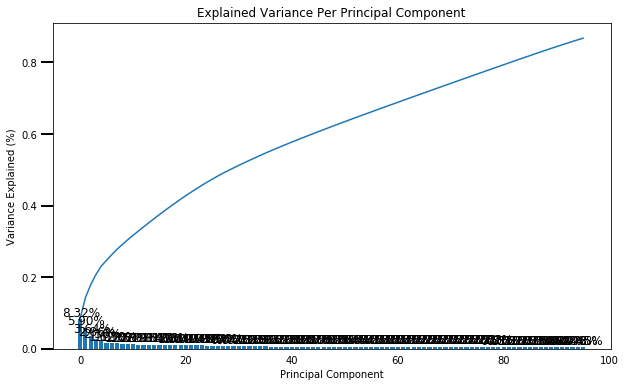

In [189]:
# Investigate the variance accounted for by each principal component.

scree_plot(pca1)



,Explained Variance,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_O,OST_WEST_KZ_W,PRAE_JUGENDJAHRE_YR,PRAE_JUGENDJAHRE_MA,PRAE_JUGENDJAHRE_EW,CAMEO_INTL_2015_HH,CAMEO_INTL_2015_LS
Dimension 1,0.0832,-0.1008,0.0081,-0.1912,0.1243,-0.0977,0.0653,0.0623,0.1371,-0.1123,...,0.0562,0.0545,0.0122,0.0515,-0.0515,0.0879,-0.1123,0.0046,0.1784,-0.1114
Dimension 2,0.0591,0.2293,0.0423,0.0729,-0.2165,0.2076,-0.1944,-0.2087,0.0939,-0.0198,...,0.0102,0.0151,0.0315,0.0288,-0.0288,-0.2315,-0.0198,0.0296,0.0661,-0.0005
Dimension 3,0.0365,0.0229,-0.3406,0.1294,-0.0541,0.0486,-0.1566,-0.0412,-0.0632,0.0821,...,0.0260,0.0120,0.0007,-0.0028,0.0028,-0.0540,0.0821,-0.0187,0.0149,-0.0146
Dimension 4,0.0287,-0.0134,0.0939,-0.0126,0.0045,-0.0056,-0.0595,0.0402,-0.0092,0.2442,...,0.0079,0.0032,0.0049,-0.0406,0.0406,0.0243,0.2442,-0.0585,-0.0338,0.0115
Dimension 5,0.0236,0.0484,-0.0419,0.0272,-0.0240,0.0288,0.0494,-0.1123,0.0067,-0.1701,...,0.0123,0.0101,-0.0034,0.1365,-0.1365,-0.0269,-0.1701,0.0119,0.1252,-0.0506
Dimension 6,0.0162,-0.0145,0.0053,0.1077,0.0020,-0.0877,0.0430,-0.0793,-0.1269,0.0711,...,0.0488,0.0178,-0.0146,0.2713,-0.2713,0.0334,0.0711,-0.1589,-0.0321,0.0319
Dimension 7,0.0158,-0.0096,0.0192,-0.0371,-0.0009,-0.0836,0.0695,-0.0702,0.1192,0.0291,...,-0.0359,-0.0948,0.0290,0.3414,-0.3414,0.0061,0.0291,-0.0740,-0.0457,0.1360
Dimension 8,0.0151,0.0237,-0.0040,0.0889,-0.0125,-0.0047,-0.0343,-0.0171,-0.1751,-0.0587,...,0.0869,0.0631,0.0426,-0.1166,0.1166,0.0264,-0.0587,-0.0562,-0.0375,-0.1623
Dimension 9,0.0136,-0.0263,0.0317,-0.0822,0.0450,-0.0087,0.0710,0.0354,0.1244,0.0062,...,0.0720,0.0764,0.0666,0.0347,-0.0347,-0.0203,0.0062,0.1598,-0.0556,-0.0100
Dimension 10,0.0128,-0.0143,0.0017,-0.0267,-0.0037,0.0365,-0.0072,0.0070,0.0552,-0.0506,...,0.0073,0.0072,0.0429,-0.0329,0.0329,-0.0274,-0.0506,0.0669,-0.0616,0.0652


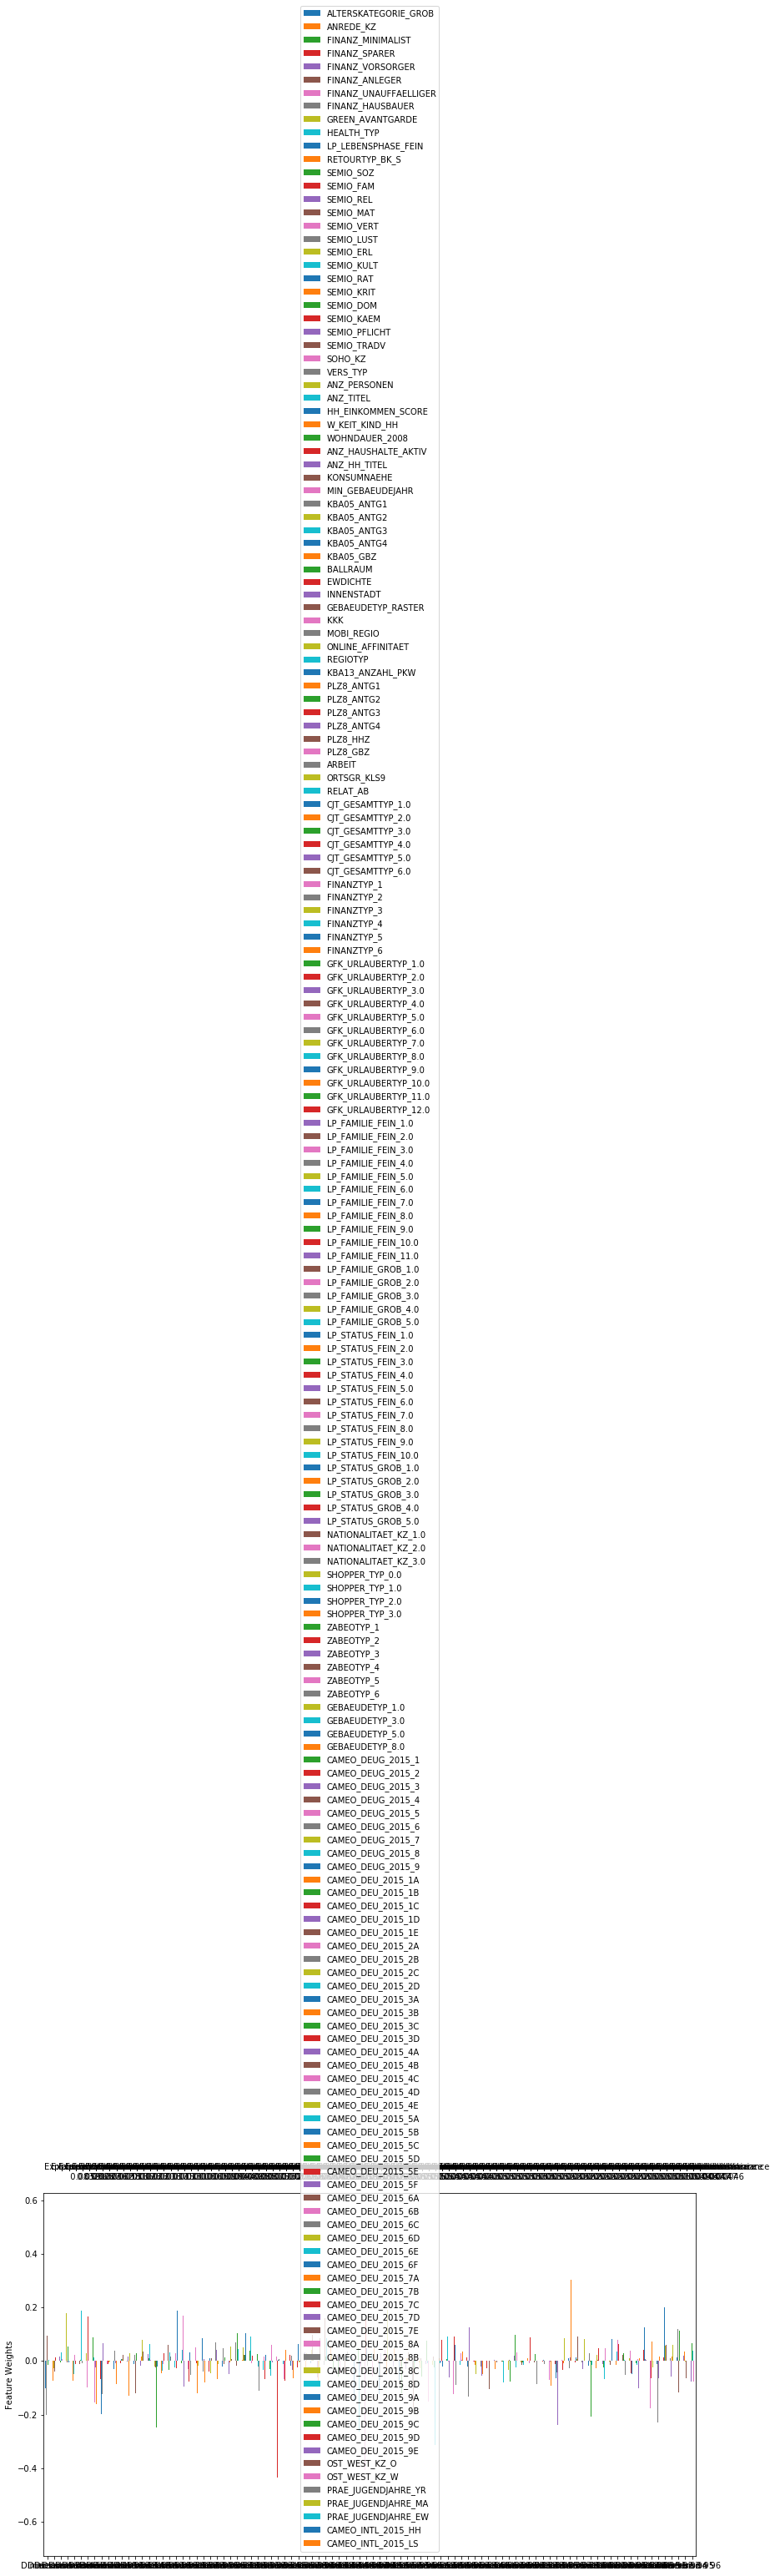

In [190]:
# Lets dig into the variance explained by each columns contribution

pca_results(azdias_ss, pca1)



Explaining the Variance chart, seems like we can reduce the number of our component analysis down to n=30

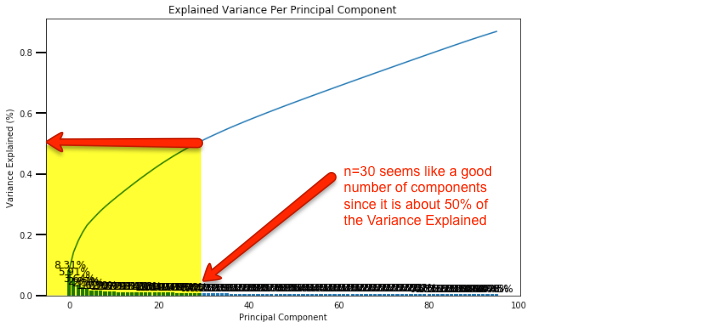

In [191]:
#Lets find what the total explanation of using this number of principle components

print('Total percentage of {}% is explained by {} components.'.format(round(pca1.explained_variance_ratio_.sum()*100,2),
                                                                      len(pca1.explained_variance_ratio_)))

Total percentage of 86.78% is explained by 96 components.


In [192]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca2 = PCA(30)
azdias_pca2 = pca2.fit_transform(azdias_ss)


,Explained Variance,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_O,OST_WEST_KZ_W,PRAE_JUGENDJAHRE_YR,PRAE_JUGENDJAHRE_MA,PRAE_JUGENDJAHRE_EW,CAMEO_INTL_2015_HH,CAMEO_INTL_2015_LS
Dimension 1,0.0832,-0.1008,0.0081,-0.1912,0.1243,-0.0977,0.0653,0.0623,0.1371,-0.1123,...,0.0562,0.0545,0.0122,0.0515,-0.0515,0.0879,-0.1123,0.0046,0.1784,-0.1114
Dimension 2,0.0591,0.2293,0.0423,0.0729,-0.2165,0.2076,-0.1944,-0.2087,0.0939,-0.0198,...,0.0102,0.0151,0.0315,0.0288,-0.0288,-0.2315,-0.0198,0.0296,0.0661,-0.0005
Dimension 3,0.0365,0.0229,-0.3406,0.1294,-0.0541,0.0486,-0.1566,-0.0412,-0.0632,0.0821,...,0.0260,0.0120,0.0006,-0.0028,0.0028,-0.0540,0.0821,-0.0187,0.0149,-0.0146
Dimension 4,0.0287,-0.0134,0.0939,-0.0126,0.0045,-0.0056,-0.0595,0.0402,-0.0092,0.2442,...,0.0079,0.0033,0.0050,-0.0406,0.0406,0.0243,0.2442,-0.0586,-0.0338,0.0115
Dimension 5,0.0236,0.0485,-0.0419,0.0272,-0.0240,0.0289,0.0495,-0.1123,0.0067,-0.1701,...,0.0122,0.0102,-0.0034,0.1365,-0.1365,-0.0269,-0.1701,0.0119,0.1251,-0.0506
Dimension 6,0.0162,-0.0147,0.0053,0.1077,0.0021,-0.0879,0.0433,-0.0793,-0.1265,0.0711,...,0.0493,0.0183,-0.0135,0.2724,-0.2724,0.0335,0.0711,-0.1576,-0.0319,0.0326
Dimension 7,0.0158,-0.0097,0.0192,-0.0373,-0.0008,-0.0834,0.0695,-0.0704,0.1190,0.0293,...,-0.0374,-0.0949,0.0287,0.3398,-0.3398,0.0059,0.0293,-0.0741,-0.0472,0.1354
Dimension 8,0.0151,0.0232,-0.0038,0.0901,-0.0127,-0.0048,-0.0343,-0.0170,-0.1758,-0.0587,...,0.0883,0.0618,0.0418,-0.1165,0.1165,0.0266,-0.0587,-0.0556,-0.0356,-0.1625
Dimension 9,0.0135,-0.0268,0.0324,-0.0802,0.0447,-0.0090,0.0712,0.0367,0.1221,0.0059,...,0.0753,0.0764,0.0675,0.0344,-0.0344,-0.0197,0.0059,0.1616,-0.0507,-0.0109
Dimension 10,0.0128,-0.0152,0.0022,-0.0257,-0.0030,0.0356,-0.0066,0.0089,0.0535,-0.0524,...,0.0092,0.0062,0.0439,-0.0340,0.0340,-0.0263,-0.0524,0.0680,-0.0589,0.0679


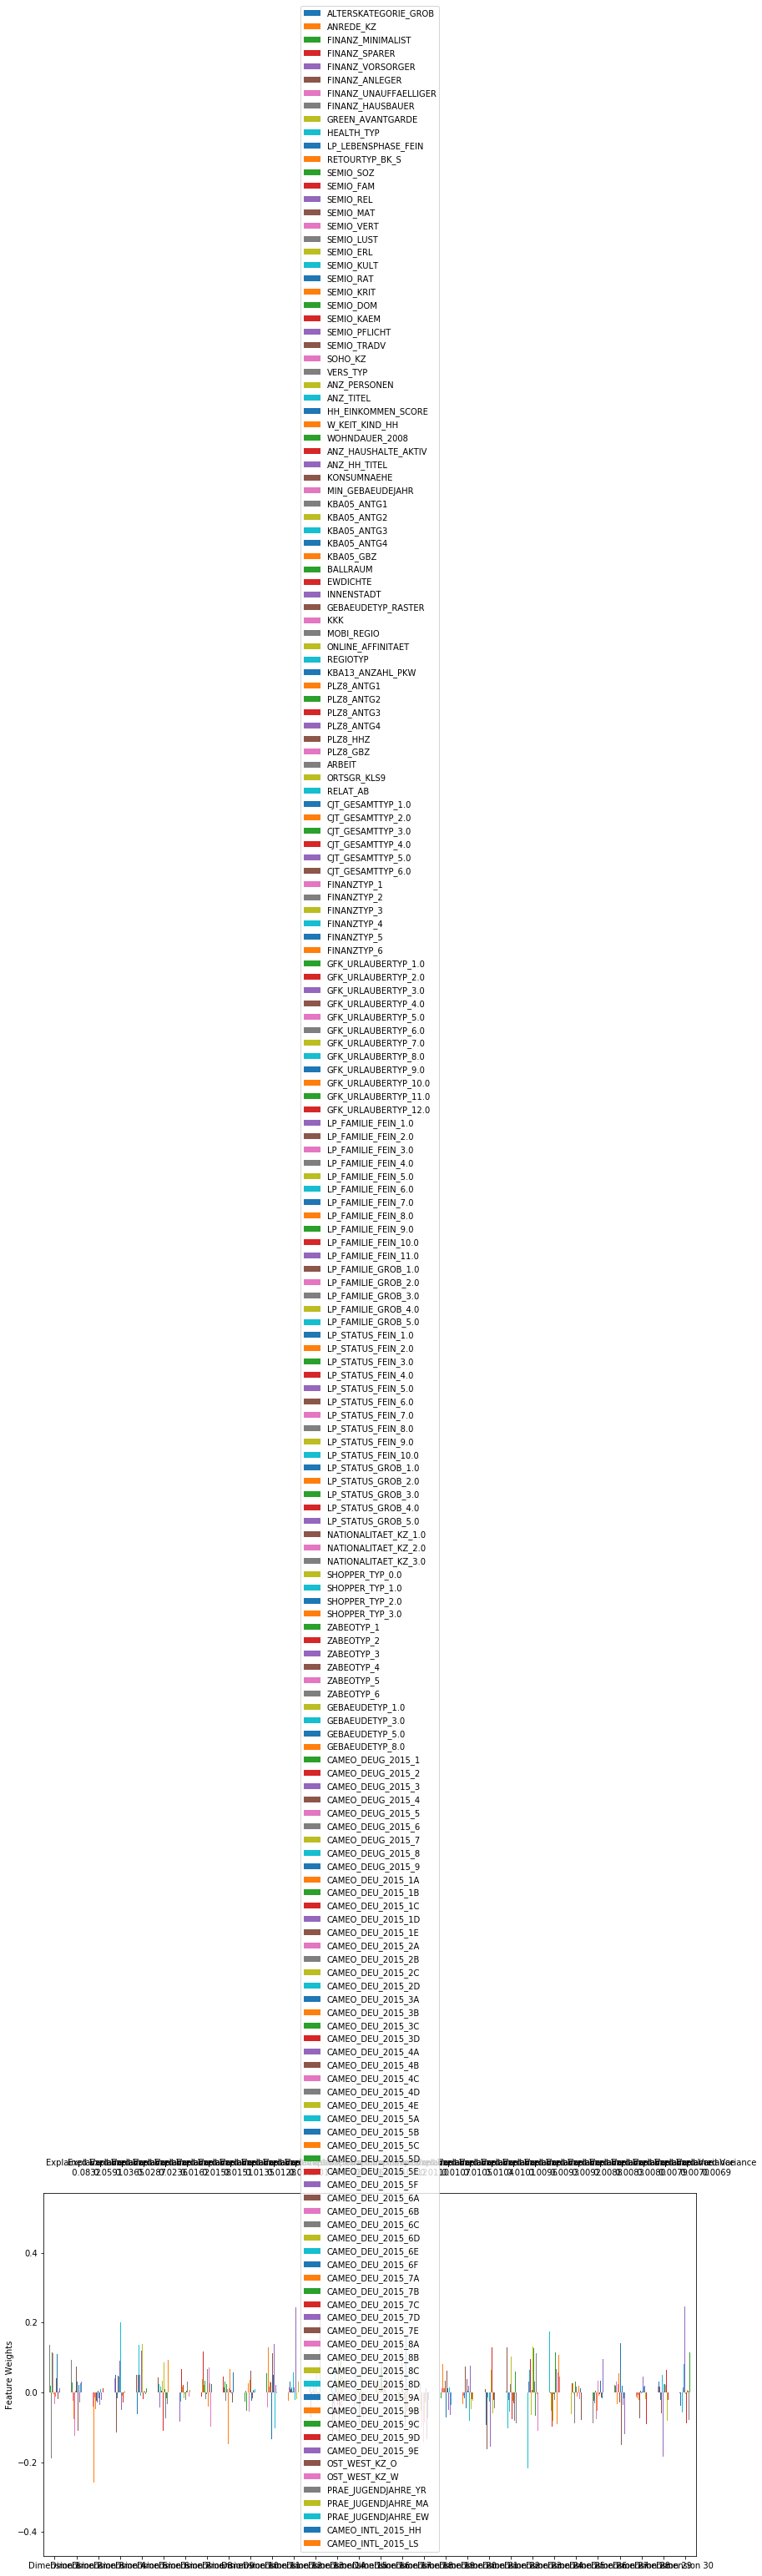

In [193]:
pca_results(azdias_ss, pca2)




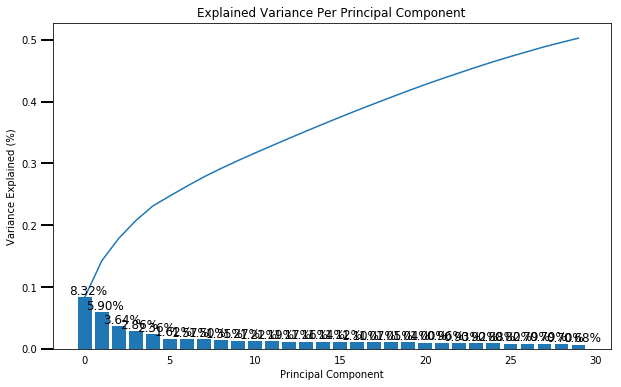

In [194]:
# Re-investigate the variance accounted for by each principal component.

scree_plot(pca2)


In [195]:
#Find what the total explanation of using this number of principle components

print('Total percentage of {}% is explained by {} components.'.format(round(pca2.explained_variance_ratio_.sum()*100,2),
                                                                      len(pca2.explained_variance_ratio_)))

Total percentage of 50.26% is explained by 30 components.


In [196]:
pca3 = PCA(20)
azdias_pca3 = pca3.fit_transform(azdias_ss)


In [197]:
azdias_pca3.shape


(623209, 20)

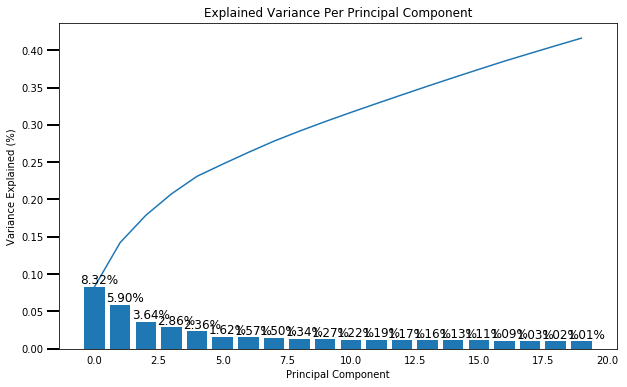

In [198]:
scree_plot(pca3)


In [199]:
#Lets find what the total explanation of using this number of principle components

print('Total percentage of {}% is explained by {} components.'.format(round(pca3.explained_variance_ratio_.sum()*100,2),
                                                                      len(pca3.explained_variance_ratio_)))

Total percentage of 41.61% is explained by 20 components.


,Explained Variance,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_O,OST_WEST_KZ_W,PRAE_JUGENDJAHRE_YR,PRAE_JUGENDJAHRE_MA,PRAE_JUGENDJAHRE_EW,CAMEO_INTL_2015_HH,CAMEO_INTL_2015_LS
Dimension 1,0.0832,-0.1008,0.0081,-0.1912,0.1243,-0.0977,0.0653,0.0623,0.1371,-0.1123,...,0.0562,0.0545,0.0122,0.0515,-0.0515,0.0879,-0.1123,0.0046,0.1784,-0.1114
Dimension 2,0.0591,0.2293,0.0423,0.0729,-0.2165,0.2076,-0.1944,-0.2087,0.0939,-0.0198,...,0.0102,0.0151,0.0315,0.0288,-0.0288,-0.2315,-0.0198,0.0296,0.0661,-0.0005
Dimension 3,0.0365,0.0229,-0.3406,0.1294,-0.0541,0.0487,-0.1566,-0.0412,-0.0632,0.0821,...,0.0259,0.0120,0.0007,-0.0029,0.0029,-0.0541,0.0821,-0.0187,0.0149,-0.0145
Dimension 4,0.0287,-0.0136,0.0940,-0.0126,0.0043,-0.0053,-0.0596,0.0400,-0.0091,0.2441,...,0.0078,0.0034,0.0049,-0.0406,0.0406,0.0241,0.2441,-0.0584,-0.0337,0.0114
Dimension 5,0.0236,0.0488,-0.0420,0.0273,-0.0238,0.0284,0.0493,-0.1117,0.0061,-0.1700,...,0.0126,0.0097,-0.0041,0.1360,-0.1360,-0.0265,-0.1700,0.0115,0.1251,-0.0507
Dimension 6,0.0162,-0.0115,0.0047,0.1087,0.0042,-0.0925,0.0435,-0.0753,-0.1324,0.0725,...,0.0467,0.0183,-0.0140,0.2696,-0.2696,0.0369,0.0725,-0.1600,-0.0300,0.0254
Dimension 7,0.0158,-0.0083,0.0188,-0.0345,-0.0006,-0.0872,0.0685,-0.0672,0.1142,0.0309,...,-0.0331,-0.0940,0.0262,0.3407,-0.3407,0.0079,0.0309,-0.0756,-0.0446,0.1354
Dimension 8,0.0150,0.0239,-0.0039,0.0881,-0.0108,-0.0055,-0.0317,-0.0165,-0.1744,-0.0592,...,0.0877,0.0714,0.0457,-0.1158,0.1158,0.0261,-0.0592,-0.0467,-0.0341,-0.1661
Dimension 9,0.0135,-0.0157,0.0289,-0.0844,0.0510,-0.0207,0.0742,0.0438,0.1219,0.0138,...,0.0718,0.0743,0.0584,0.0418,-0.0418,-0.0127,0.0138,0.1567,-0.0577,-0.0212
Dimension 10,0.0128,-0.0130,0.0037,-0.0281,-0.0018,0.0335,-0.0050,0.0126,0.0575,-0.0429,...,0.0073,0.0127,0.0421,-0.0350,0.0350,-0.0274,-0.0429,0.0731,-0.0572,0.0689


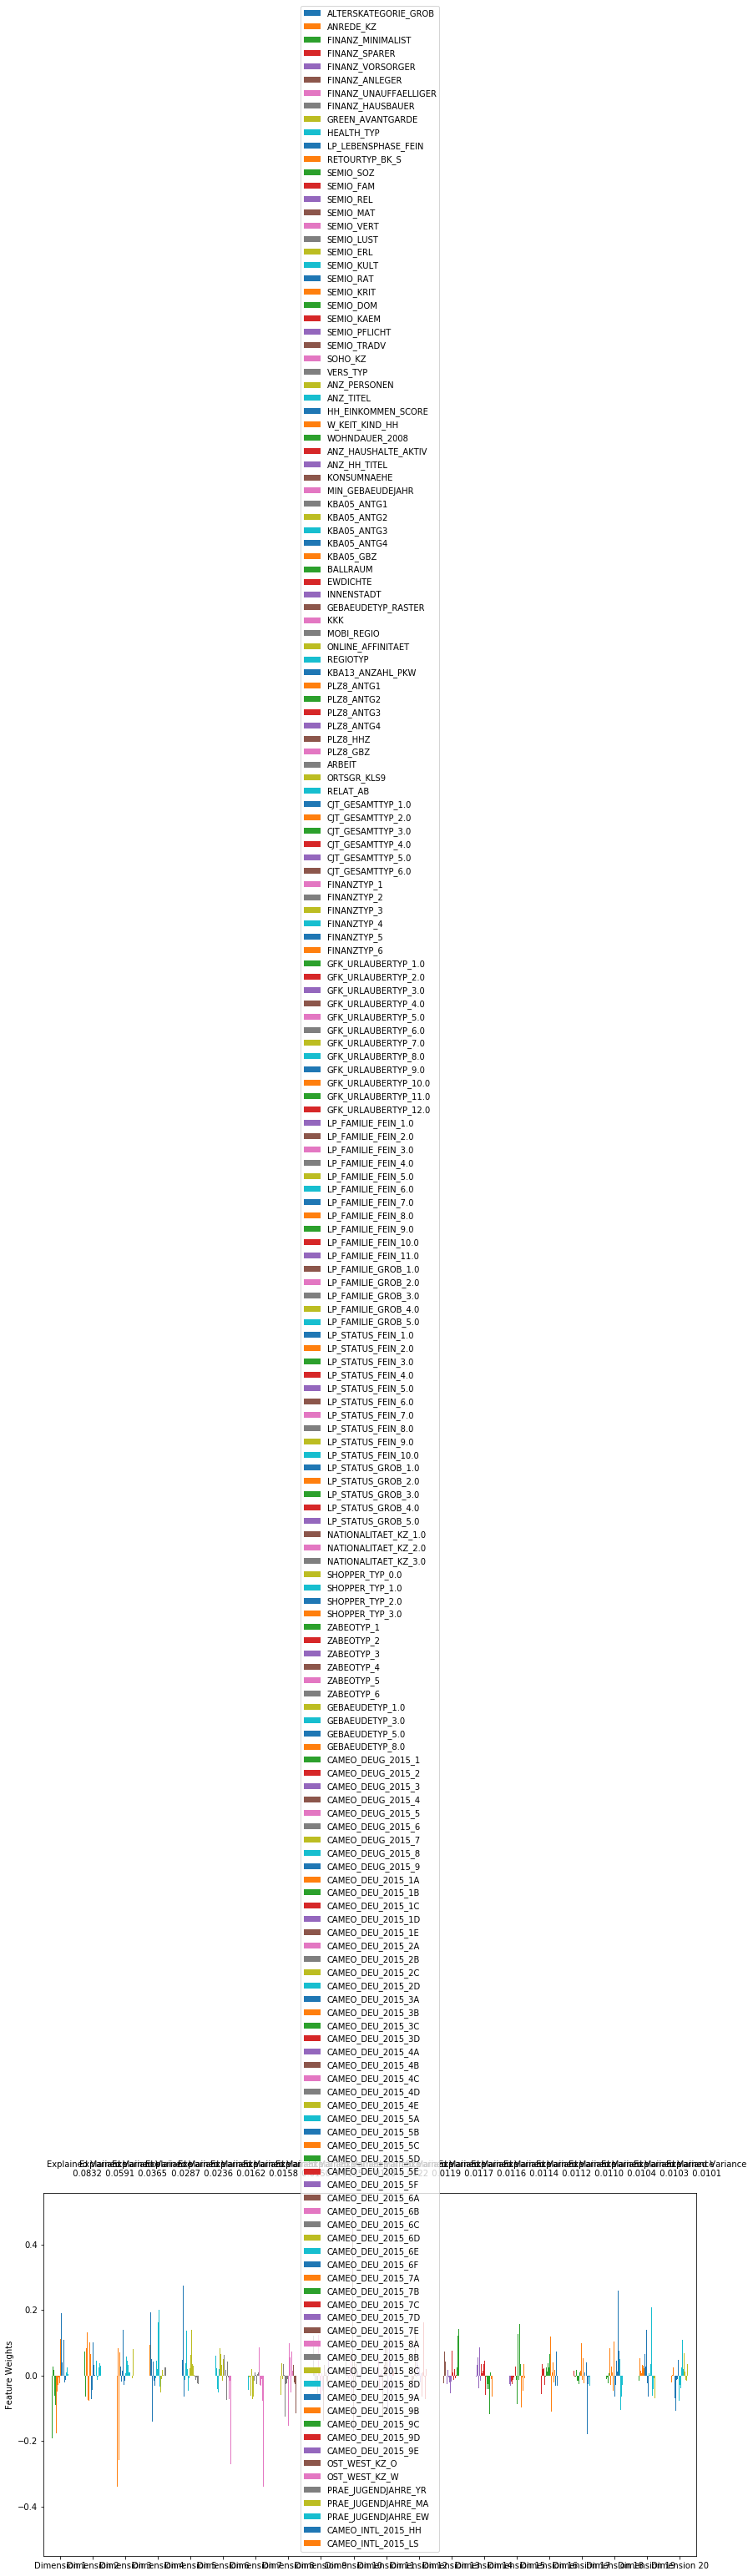

In [201]:
pca_results(azdias_ss, pca3)


### Discussion 2.2: Perform Dimensionality Reduction

Here are my findings and decisions regarding dimensionality reduction. I instanstiated and fit a PCA model to the Standard Scaled data. I used half the of the dataset components (columns). After fitting I analyzed the variance_ratio details and found 86.8% is explained by 96 components. Looking at the 'Explained Variance Per Principal Component' chart it seems like 50% layed when using 30 components. Sure enough, after fitting this new model I found exactly 50.23%. I thought it would interesting to see if I halved this number of components would that halve my total explained ratio. When I re did the analysis with n=20 I got ~42% of total explained ratio but this analysis ran 10x faster then the initial run. Which seems it would depend on how accurate you want your prediction and how my time and computation you have. If want a quick and dirty analysis to understand 2/5th of what insights your data is telling you could use less then 1/10th of the columns verses running for longer time to squeeze our every percentage out.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [202]:
pca_comp = pd.DataFrame(pca3.components_)
pca_comp.columns = azdias_ss.columns
pca_comp2 = pca_comp.sort_values([0], axis=1, ascending=False)
pca_comp2


,LP_STATUS_GROB_1.0,HH_EINKOMMEN_SCORE,CAMEO_INTL_2015_HH,PLZ8_ANTG3,PLZ8_ANTG4,ORTSGR_KLS9,EWDICHTE,FINANZ_HAUSBAUER,FINANZ_SPARER,LP_STATUS_FEIN_1.0,...,LP_STATUS_GROB_5.0,LP_STATUS_FEIN_10.0,KONSUMNAEHE,PLZ8_GBZ,LP_LEBENSPHASE_FEIN,PLZ8_ANTG1,KBA05_GBZ,KBA05_ANTG1,FINANZ_MINIMALIST,MOBI_REGIO
0,0.190465,0.180350,0.178422,0.173940,0.168485,0.144854,0.142305,0.137139,0.124288,0.124206,...,-0.122577,-0.122577,-0.127048,-0.131349,-0.138987,-0.176765,-0.176847,-0.188888,-0.191242,-0.200018
1,0.031973,0.043745,0.066056,0.075956,0.071887,0.069118,0.069407,0.093873,-0.216540,0.102616,...,-0.005609,-0.005609,-0.053596,-0.059501,-0.057228,-0.076061,-0.073501,-0.070328,0.072859,-0.075850
2,-0.016085,-0.046388,0.014893,0.051387,0.051773,0.069009,0.070295,-0.063233,-0.054084,0.043568,...,0.057230,0.057230,-0.052417,-0.034034,0.006296,-0.047968,-0.023804,-0.017348,0.129427,-0.027718
3,0.008564,-0.141671,-0.033703,0.116513,0.111737,0.203938,0.207754,-0.009056,0.004312,-0.001284,...,0.200930,0.200930,-0.114987,-0.050832,0.193548,-0.086409,-0.042206,-0.006033,-0.012558,-0.032085
4,0.064201,0.097388,0.125061,0.023415,0.040408,-0.035495,-0.055240,0.006096,-0.023777,0.066111,...,-0.114216,-0.114216,0.049739,-0.111478,0.275803,-0.052073,-0.046176,-0.054319,0.027300,-0.040327
5,0.040766,-0.078414,-0.030022,0.015091,0.051391,0.082428,0.039795,-0.132407,0.004214,0.017482,...,0.186890,0.186890,0.067822,-0.163110,-0.090375,-0.035431,0.053821,0.071070,0.108652,0.063104
6,-0.134986,-0.022594,-0.044621,-0.012536,0.030609,-0.072578,-0.104965,0.114166,-0.000593,-0.152572,...,-0.096844,-0.096844,-0.002032,-0.106531,-0.012720,-0.043882,0.004479,-0.030558,-0.034538,-0.003925
7,-0.009577,-0.026207,-0.034053,-0.047208,0.025511,-0.003516,-0.000245,-0.174421,-0.010769,0.056550,...,-0.088831,-0.088831,-0.065901,0.007749,-0.004061,0.021481,0.007437,0.036408,0.088143,0.002440
8,0.112536,-0.031469,-0.057651,-0.050717,0.014260,-0.059779,-0.067301,0.121877,0.050971,0.009195,...,0.080044,0.080044,0.040391,-0.001302,0.030075,0.047640,-0.052880,0.011544,-0.084354,-0.025419
9,0.081550,-0.037681,-0.057165,-0.035426,0.010732,-0.014917,-0.012263,0.057478,-0.001786,0.020056,...,-0.028498,-0.028498,0.005383,0.025339,-0.079875,0.037058,-0.050454,-0.004849,-0.028132,-0.029690


In [203]:
#Function that prints the contribution associated with each component to understand how the weighting
def get_contributions(dataset, comp):
    pca_comp = pd.DataFrame(pca3.components_)
    pca_comp.columns = dataset.columns
    row = pca_comp.index[comp]
    pca_by_comp = pca_comp.sort_values(by=row, ascending=False, axis=1)
    percentage = round(pca3.explained_variance_ratio_[comp]*100,2)
    print('For {:>2} component(s) the top feature {:<20} contributes to the total of {}%'.format(comp, 
                                                                                 pca_by_comp.columns[0], 
                                                                                 percentage))

In [204]:
for i in range(20):
    get_contributions(azdias_ss, i)

For  0 component(s) the top feature LP_STATUS_GROB_1.0   contributes to the total of 8.32%
For  1 component(s) the top feature ALTERSKATEGORIE_GROB contributes to the total of 5.91%
For  2 component(s) the top feature SEMIO_VERT           contributes to the total of 3.65%
For  3 component(s) the top feature PRAE_JUGENDJAHRE_MA  contributes to the total of 2.87%
For  4 component(s) the top feature LP_LEBENSPHASE_FEIN  contributes to the total of 2.36%
For  5 component(s) the top feature OST_WEST_KZ_O        contributes to the total of 1.62%
For  6 component(s) the top feature OST_WEST_KZ_O        contributes to the total of 1.58%
For  7 component(s) the top feature GEBAEUDETYP_3.0      contributes to the total of 1.5%
For  8 component(s) the top feature LP_FAMILIE_GROB_5.0  contributes to the total of 1.35%
For  9 component(s) the top feature LP_FAMILIE_GROB_2.0  contributes to the total of 1.28%
For 10 component(s) the top feature LP_STATUS_GROB_4.0   contributes to the total of 1.22%


In [205]:
# Function to map weights for the first principal component to corresponding feature names sorted 
def get_weights(pca, item):
    pca_comp = pd.DataFrame(pca.components_)
    pca_comp.columns = azdias_ss.columns
    pca_comp2 = pca_comp.sort_values([item], axis=1, ascending=False).iloc[item]

    most_col1, most_col2, most_col3  = pca_comp2.index[0], pca_comp2.index[1], pca_comp2.index[2]
    most_val1, most_val2, most_val3  = pca_comp2.values[0], pca_comp2.values[1], pca_comp2.values[2]

    least_col1, least_col2, least_col3  = pca_comp2.index[-1], pca_comp2.index[-2], pca_comp2.index[-3]
    least_val1, least_val2, least_val3  = pca_comp2.values[-1], pca_comp2.values[-2], pca_comp2.values[-3]



    print('Principal component: {:2}'.format(item))
    print('1st  most column contribution {:<21} with value {:>3f}'.format(most_col1, most_val1))
    print('2nd  most column contribution {:<21} with value {:>3f}'.format(most_col2, most_val2))
    print('3rd  most column contribution {:<21} with value {:>3f}'.format(most_col3, most_val3))

    print('3rd Least column contribution {:<21} with value {:>3f}'.format(least_col3, least_val3))
    print('2nd Least column contribution {:<21} with value {:>3f}'.format(least_col2, least_val2))
    print('1st Least column contribution {:<21} with value {:>3f}'.format(least_col1, least_val1))



    
    print('\n')
    

In [206]:
for i in range(5):
    get_weights(pca3, i)
    
    

Principal component:  0
1st  most column contribution LP_STATUS_GROB_1.0    with value 0.190465
2nd  most column contribution HH_EINKOMMEN_SCORE    with value 0.180350
3rd  most column contribution CAMEO_INTL_2015_HH    with value 0.178422
3rd Least column contribution KBA05_ANTG1           with value -0.188888
2nd Least column contribution FINANZ_MINIMALIST     with value -0.191242
1st Least column contribution MOBI_REGIO            with value -0.200018


Principal component:  1
1st  most column contribution ALTERSKATEGORIE_GROB  with value 0.229347
2nd  most column contribution FINANZ_VORSORGER      with value 0.207554
3rd  most column contribution ZABEOTYP_3            with value 0.200330
3rd Least column contribution FINANZ_SPARER         with value -0.216540
2nd Least column contribution SEMIO_REL             with value -0.217437
1st Least column contribution PRAE_JUGENDJAHRE_YR   with value -0.231455


Principal component:  2
1st  most column contribution SEMIO_VERT            wi

### Discussion 2.3: Interpret Principal Components

Here I will report my observations from detailed investigation of the first couple principal components generated above. The  I will discuss the first three components as they make up the biggest contributions percentage wise (8.32%, 5.91% and 3.65% respectively).

For the first principal component (comp 0 - 8.32%) we see the three most influencial features in the POSITIVE direction are 1st most - LP_STATUS_GROB_1.0 (Social status - low to top income earners), 2nd - HH_EINKOMMEN_SCORE(Estimated household net income highest to very low income), and 3rd most - CAMEO_INTL_2015_HH (Wealthy to poorer Households) 

For the first principal component (comp 0) we see the three most influencial features in the NEGATIVE direction are
3rd Least - KBA05_ANTG1 (Number of 1-2 family houses in the microcell - lower share to very high share of 1-2 family homes), 2nd Least - FINANZ_MINIMALIST (low financial interest) and 1st Least feature is MOBI_REGIO (Movement patterns - very high to very low movement).

We can see this makes sense as more wealthy households with high social status top income earners tend to be the opposite of what we see in the contributions to the negative side, which is high affinity to sharing family homes with others, highly minimalist as they don't have alot of money to buy things and high movement habits due to needing to maybe find cheaper or safer housing, or even evictions. All characteristics of a lower social class.


For the second principal component (comp 1 - 5.91%) we see the three most influencial features in the POSITIVE direction are 1st most - ALTERSKATEGORIE_GROB (Estimated age based on given name analysis, <30 to >60 years old), 
2nd  most - FINANZ_VORSORGER (Financial topology - 'be prepared' thinking), and 3rd most contribution - ZABEOTYP_3 (
Energy consumption typology - fair supplied, middle of green and indifferent).

For the first principal component (comp 1) we see the three most influencial features in the NEGATIVE direction are
3rd Least - FINANZ_SPARER (Financial topology - money-saver), 2nd Least - SEMIO_REL (highest affinity to being religious), and most least column contribution - PRAE_JUGENDJAHRE_YR (Dominating movement of person's youth (40s to 90s).

And here too we can see this makes somewhat sense. Analysis seems to indicate the individuals are older and might have more world experience to have a 'prepared' mindset as older people know what it might take for a 'rainy day' of hard times. They seem not to be so interested conserving on energy consumption as maybe they once lived in a world in their youth that wasn't so energy conscieneous like todays youth. They may be taking their 'fair supply' as they might feel they have earned it and don't need to converse the environment at this won't be their problem in the coming years. Seems like being a money-saver and highly religious has the negative affect.

For the third principal component (comp 2 - 3.65%) we see the three most influencial features in the POSITIVE direction are low affinity to individuals being of personality that are considered SEMIO_VERT (dreamful), SEMIO_FAM (family-oriented) and SEMIO_SOZ (socially-minded) verses the opposite of being SEMIO_DOM (dominant-minded), SEMIO_KAEM (combative) and ANREDE_KZ (male). Makes sense if you are male that has a dominating and combative attitude you tend not to be popular in social and family surroundings.



## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [207]:
#Function to fit and compute score on KMeans fit. Code provided in Lesson 01-10 of Udacity DS course.


def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score



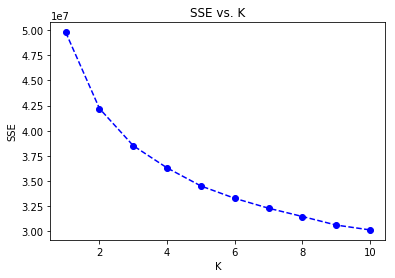

In [208]:
#Perform kMeans clustering on the PCA transformed data (ie. X_pca = pca3.fit_transform(azdias_ss))
# Over a number of different cluster counts run k-means clustering on the data and compute the score
# and plot score on KMeans fit to try to see the 'elbow' point of best fit number of clusters

data = azdias_pca3
scores = []
centers = list(range(1,11))

for center in centers:
    scores.append(get_kmeans_score(data, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');


In [235]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters=5)      #instantiate kmeans
model = kmeans.fit(data)           # Then fit the model to your data using the fit method
azdias_klabels = model.predict(data)       #predict the labels on the same data to show the category


In [236]:
df=pd.DataFrame(azdias_klabels)
df.shape

(623209, 1)

### Discussion 3.1: Apply Clustering to General Population

After instantiating and fitting the PCA data to the KMeans model I ran the SSE score on various clusters from 1 to 11. I didn't seem to see the 'elbow' was clear as was demomstrated in the class lesson so I make a decision to take N as 6 since it seems to be when the scoring is losing momentum on the downward direction:

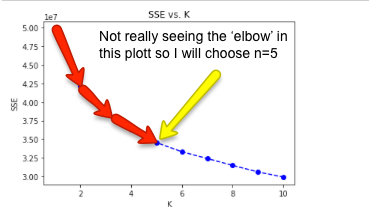



### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [237]:
# Load in the customer demographics data.
# Apply preprocessing, feature transformation

#Already done!!!

As previously demostrated in step 1, all customer loading, preprocessing, and transformation steps were completed for the Customer_recoded dataset along the way and confirmed it is ready for this step. No more tasks needed to take here!

In [238]:
# Apply feature scaling to the customer population demographics data.

#scaler = p.StandardScaler() #don't need to recreate another instance of StandardScaler

customer_ss = pd.DataFrame(scaler.transform(customer_recoded)) # Just need to transform, & use std scaler

#labels = fit_kmeans(azdias_ss, 10) #fit kmeans to get the labels    
#plt.scatter(azdias_ss['height'], azdias_ss['weight'], c=labels, cmap='Set3');



In [239]:
customer_ss.head(2)

,0,1,2,3,4,5,6,7,8,9,...,182,183,184,185,186,187,188,189,190,191
0,1.176307,-1.022678,1.427283,-1.141401,1.114984,-1.221857,-0.410328,-0.856545,1.806129,-1.591638,...,-0.185007,-0.196619,-0.075861,-0.519209,0.519209,-1.591253,1.806129,0.521791,-1.595957,0.082845
1,1.176307,0.977825,1.427283,-1.141401,1.114984,-1.221857,1.047073,0.608140,1.806129,-0.273496,...,-0.185007,-0.196619,-0.075861,-0.519209,0.519209,-1.591253,1.806129,0.521791,-0.224038,0.749822


In [240]:
#Now need to add the column names and row indices from the old dataset as we did before:
customer_ss.columns = customer_recoded.columns
customer_ss.index = customer_recoded.index


In [241]:
customer_ss.head(2)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_O,OST_WEST_KZ_W,PRAE_JUGENDJAHRE_YR,PRAE_JUGENDJAHRE_MA,PRAE_JUGENDJAHRE_EW,CAMEO_INTL_2015_HH,CAMEO_INTL_2015_LS
0,1.176307,-1.022678,1.427283,-1.141401,1.114984,-1.221857,-0.410328,-0.856545,1.806129,-1.591638,...,-0.185007,-0.196619,-0.075861,-0.519209,0.519209,-1.591253,1.806129,0.521791,-1.595957,0.082845
2,1.176307,0.977825,1.427283,-1.141401,1.114984,-1.221857,1.047073,0.608140,1.806129,-0.273496,...,-0.185007,-0.196619,-0.075861,-0.519209,0.519209,-1.591253,1.806129,0.521791,-0.224038,0.749822


In [242]:
customer_ss.shape

(115643, 192)

In [243]:
#Now perform PCA on the new standarded customer_ss dataset
#pca3 = PCA(20)     - don't need to reinstantiate pca model or fit just use transform on customer data
customer_pca3 = pca3.transform(customer_ss)     #only 'transform' not using 'fit_transform' as before


In [244]:
#clustering from the general demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data. 
#Use KMeans model from section 3.1 so only need to do 'predict'

customer_klabels = model.predict(customer_pca3)



In [245]:
customer_klabels


array([3, 3, 4, ..., 3, 1, 1], dtype=int32)

In [246]:
azdias_klabels


array([0, 2, 4, ..., 0, 0, 4], dtype=int32)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

### Compare the proportion of data in each cluster for the customer data to the proportion of data in each cluster for the general population.

In [247]:
#Function to take in KMeans predicted labels, and beginning dataset and return a list of percentage of rows/dataset
# It also plots a bar chart of this percentage. Note, this includes the missing data

def make_cluster_percents(dataset_klabels, init_dataset) :

    predictions = pd.DataFrame(dataset_klabels, columns=['label'])

    clusters_count = {}
    init_rows = len(init_dataset)
    
    #Get number of discarded data rows for the particular Population
    discarded_prop = round(((init_rows - len(dataset_klabels))/init_rows)*100,2)

    #Add this missing row count to cluster number '-1'
    clusters_count[-1] = discarded_prop
        
    ttl_clusters = len(predictions['label'].unique())  #find the total number of clusters used
    for i in range(ttl_clusters):
        rows_per_cluster = predictions.loc[predictions.label == i, :].count()[0]
        clusters_count[i] = round((rows_per_cluster/init_rows)*100,2)

    #Plot out a simple bar chart to see % of each cluster of the total initial dataset

    if init_rows > 500000:
        chart_title = 'General Population % of Initial Data'
        col = 'b'
    else:
        chart_title = 'Customer Population % of Initial Data'
        col = 'g'


    plt.bar(range(len(clusters_count)), list(clusters_count.values()), align='center', color=col, alpha=0.5
           )
    plt.xticks(range(len(clusters_count)), list(clusters_count.keys()))
    plt.title(chart_title)
    plt.xlabel('Cluster Number')
    plt.ylabel('% of Initial Dataset')
    plt.show()
        


    return clusters_count

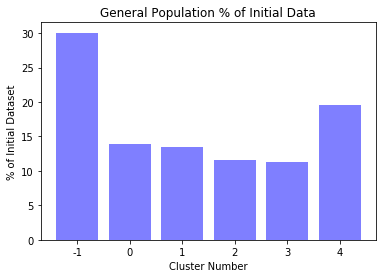

{-1: 30.07,
 0: 13.960000000000001,
 1: 13.49,
 2: 11.539999999999999,
 3: 11.35,
 4: 19.579999999999998}

In [248]:
gen_pop_clusters_count = make_cluster_percents(azdias_klabels, azdias)

gen_pop_clusters_count

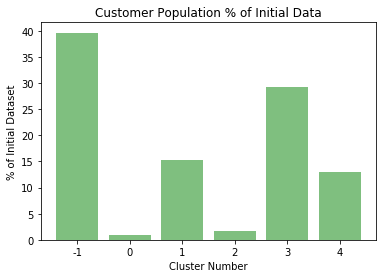

{-1: 39.66,
 0: 0.96999999999999997,
 1: 15.33,
 2: 1.71,
 3: 29.300000000000001,
 4: 13.039999999999999}

In [249]:
customer_clusters_count = make_cluster_percents(customer_klabels, customers)

customer_clusters_count

These bar charts look great, but we need to see the relative difference between the bars proportions.


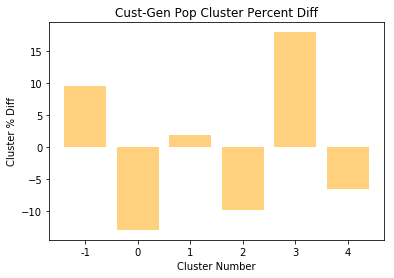

In [250]:
#Function to plot the difference the Customer percentage - Gen Population percentage
#ie. if the value is positive this is GOOD target and if negative this is target audience that is not interested

percent_diff = {}
for i in list(customer_clusters_count.keys()):
    percent_diff[i] = round(customer_clusters_count[i] - gen_pop_clusters_count[i],2)
    
percent_diff


plt.bar(range(len(percent_diff)), list(percent_diff.values()), align='center', color='orange', alpha=0.5)
plt.xticks(range(len(percent_diff)), list(percent_diff.keys()))
plt.title('Cust-Gen Pop Cluster Percent Diff')
plt.xlabel('Cluster Number')
plt.ylabel('Cluster % Diff')
plt.show()

We can see in the difference in the proportional percentages above that the 1st cluster (label #0)  is the most UNDER represented from our analysis while 4th cluster (label #3) is the most OVER represented in our customer dataset.

In [270]:
# Function to get top 3 and last 3 original dataset column names that correspond to a specfic principal component

def get_columns_name(pca, comp_num):
    pca_comp = pd.DataFrame(pca.components_)    #this is a dataframe of Components vs. Columns
    pca_comp.columns = azdias_ss.columns
    pca_comp2 = pca_comp.sort_values([comp_num], axis=1, ascending=False).iloc[comp_num]    

    #Retrieve top 3 positive and negative contributing column names
    most_col1, most_col2, most_col3  = pca_comp2.index[0], pca_comp2.index[1], pca_comp2.index[2]
    least_col1, least_col2, least_col3  = pca_comp2.index[-1], pca_comp2.index[-2], pca_comp2.index[-3]

    print('The following columns that have the most POSITIVE contribution to this cluster:')
    print('1st  most column contribution {:<21}'.format(most_col1))
    print('2nd  most column contribution {:<21}'.format(most_col2))
    print('3rd  most column contribution {:<21}'.format(most_col3))
#    print('\n')

    print('The following columns that have the most NEGITIVE contribution to this cluster:')
    print('3rd Least column contribution {:<21}'.format(least_col3))
    print('2nd Least column contribution {:<21}'.format(least_col2))
    print('1st Least column contribution {:<21}'.format(least_col1))
#    print('\n')
    

In [271]:
#Function that receives a dataframe of row of a specific KMeans cluster number and aggregates a list of the top
# most contributing PCA component for EACH row in that cluster dataframe.

def get_hi_low_components(rows_in_cluster):

    hi_low_comp_dict = {'most_comp1':[] }
    
#    , 'most_comp2':[],'most_comp3':[],'least_comp1':[], 'least_comp2':[], 'least_comp3':[] }
    
    #Get top 3 and last 3 component names associated with this component after sorting by each row
    for row in rows_in_cluster.index:

        df = rows_in_cluster.sort_values([row], axis=1, ascending=False)
        df = df.drop('cluster', axis=1)

        hi_low_comp_dict["most_comp1"].append(df.columns[0])
#        hi_low_comp_dict["most_comp2"].append(df.columns[1])
#        hi_low_comp_dict["most_comp3"].append(df.columns[2])

#        hi_low_comp_dict["least_comp1"].append(df.columns[-1])
#        hi_low_comp_dict["least_comp2"].append(df.columns[-2])
#        hi_low_comp_dict["least_comp3"].append(df.columns[-3])

    return hi_low_comp_dict

In [272]:
#Function to receive all clusters dataframe and parse list by cluster and find which is its highest PCA component
# this also plots a bar chart of the distribution of the rows where the components are for a particular cluster

def get_comps_and_colnames(cluster_pca_df):

    n_clusters = len(cluster_pca_df['cluster'].unique())   #get the total number of clusters 
    cluster_colors = {0:'blue', 1:'green', 2:'orange', 3:'red', 4:'purple'}
    for i in range(n_clusters):

        print('==========================================================')
        print('==============FOR CLUSTER: {} ============================='.format(i))
        print('==========================================================')
#        print('\n')


        rows_in_cluster = cluster_pca_df.loc[cluster_pca_df['cluster'] == i]
        cluster_hi_low_comp_dict = get_hi_low_components(rows_in_cluster)

        #Once you have a dict of lists for top 3 and least 3 components for each row of a particular cluster, 
        # now find the most occurring column in each of the 6 lists
        for j in cluster_hi_low_comp_dict:
            df2 = pd.Series(cluster_hi_low_comp_dict[j])
            top_comp = df2.value_counts().index[0]         #only interested in the most frequently occurring comp.
            
            print('Component {} is the most frequently occurring for cluster {}'.format(top_comp, i))
#            print('\n')
            get_columns_name(pca3, top_comp)

            counts = np.bincount(df2)
            fig, ax = plt.subplots()
            ax.bar(range(20), counts, width=0.8, align='center', color=cluster_colors[i])
            ax.set(xticks=range(20), xlim=[-1, 20])
            plt.show()
#            print('----------------------------------------------------')
            print('\n')




==============FOR CLUSTER: 0 =============================
Component 0 is the most frequently occurring for cluster 0
The following columns that have the most POSITIVE contribution to this cluster:
1st  most column contribution LP_STATUS_GROB_1.0   
2nd  most column contribution HH_EINKOMMEN_SCORE   
3rd  most column contribution CAMEO_INTL_2015_HH   
The following columns that have the most NEGITIVE contribution to this cluster:
3rd Least column contribution KBA05_ANTG1          
2nd Least column contribution FINANZ_MINIMALIST    
1st Least column contribution MOBI_REGIO           


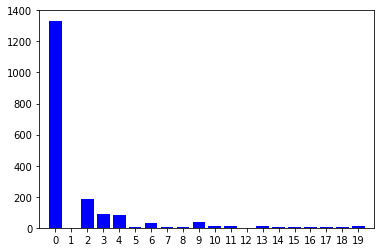



==============FOR CLUSTER: 1 =============================
Component 4 is the most frequently occurring for cluster 1
The following columns that have the most POSITIVE contribution to this cluster:
1st  most column contribution LP_LEBENSPHASE_FEIN  
2nd  most column contribution ANZ_PERSONEN         
3rd  most column contribution LP_FAMILIE_GROB_5.0  
The following columns that have the most NEGITIVE contribution to this cluster:
3rd Least column contribution W_KEIT_KIND_HH       
2nd Least column contribution LP_FAMILIE_GROB_1.0  
1st Least column contribution LP_FAMILIE_FEIN_1.0  


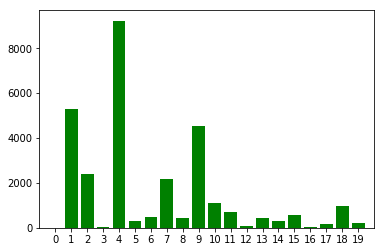



==============FOR CLUSTER: 2 =============================
Component 2 is the most frequently occurring for cluster 2
The following columns that have the most POSITIVE contribution to this cluster:
1st  most column contribution SEMIO_VERT           
2nd  most column contribution SEMIO_FAM            
3rd  most column contribution SEMIO_SOZ            
The following columns that have the most NEGITIVE contribution to this cluster:
3rd Least column contribution SEMIO_DOM            
2nd Least column contribution SEMIO_KAEM           
1st Least column contribution ANREDE_KZ            


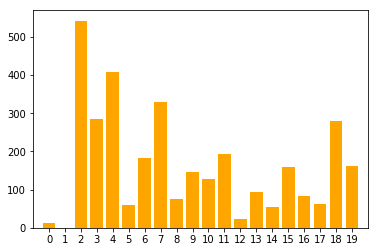



==============FOR CLUSTER: 3 =============================
Component 2 is the most frequently occurring for cluster 3
The following columns that have the most POSITIVE contribution to this cluster:
1st  most column contribution SEMIO_VERT           
2nd  most column contribution SEMIO_FAM            
3rd  most column contribution SEMIO_SOZ            
The following columns that have the most NEGITIVE contribution to this cluster:
3rd Least column contribution SEMIO_DOM            
2nd Least column contribution SEMIO_KAEM           
1st Least column contribution ANREDE_KZ            


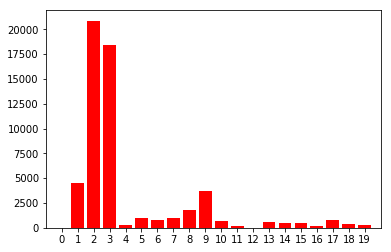



==============FOR CLUSTER: 4 =============================
Component 1 is the most frequently occurring for cluster 4
The following columns that have the most POSITIVE contribution to this cluster:
1st  most column contribution ALTERSKATEGORIE_GROB 
2nd  most column contribution FINANZ_VORSORGER     
3rd  most column contribution ZABEOTYP_3           
The following columns that have the most NEGITIVE contribution to this cluster:
3rd Least column contribution FINANZ_SPARER        
2nd Least column contribution SEMIO_REL            
1st Least column contribution PRAE_JUGENDJAHRE_YR  


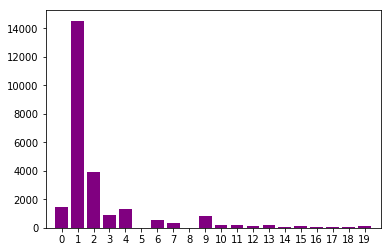



Total time to run this step took 10.7 minutes!


In [273]:
#Main call function to create a dataframe with cluster label column and past to function to 'get components 
#and column names' 

# NOTE: this can take a while to run on each component, on each row, on each cluster of the dataset.
#       the previous run times for this block was ~ 10-12 minutes!! ....thanks for your patience! ;-)

#make a data frame with correct row indices and attach cluster labels as a column
start = time.time()

cluster_pca3 = pd.DataFrame(customer_pca3)      
cluster_pca3.index = customer_ss.index
cluster_pca3['cluster'] = customer_klabels.T
get_comps_and_colnames(cluster_pca3)

end = time.time()
print('Total time to run this step took {} minutes!'.format(round((end-start)/60,1)))

I found it difficult to use the inverse.transform functions to get the cluster centers representing all columns. I therefore, created my own custom function.

#inv_pca_customer_centers = pca3.inverse_transform(customer_klabels)
#inv_scaler_customer_centers = scaler.inverse_transform(inv_pca_customer_centers)

### Which cluster or clusters are overrepresented in the customer dataset compared to the general population

As mentioned above, we found the biggest group of customers that was the overrepresented was found with rows in  the 4th cluster (or cluster 03 in above bar chart). 

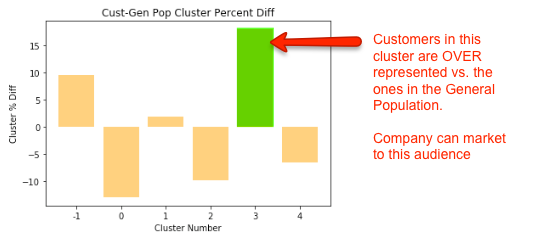


In our analysis after we trace back from the cluster level we find this maps to a PCA component that is most influential comes from component 2

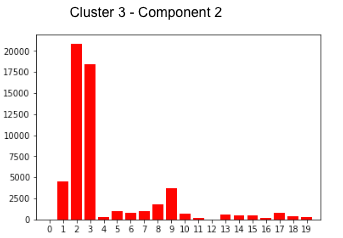


The kinds of people that are part of this cluster that reflected in the customer data are found from 

The following columns that have the most POSITIVE contribution to this cluster:
- 1st  most column contribution SEMIO_VERT (dreamful)          
- 2nd  most column contribution SEMIO_FAM (family-oriented)           
- 3rd  most column contribution SEMIO_SOZ (socially-minded)           


The following columns that have the most NEGATIVE contribution to this cluster:
- 3rd Least column contribution SEMIO_DOM (dominant-minded)          
- 2nd Least column contribution SEMIO_KAEM (combative)          
- 1st Least column contribution ANREDE_KZ (male)          


### Which cluster or clusters are underrepresented in the customer dataset compared to the general population

As mentioned above, we found the biggest group of customers that was the underrepresented was found with rows in the 1st cluster (or cluster 0 in above bar chart).

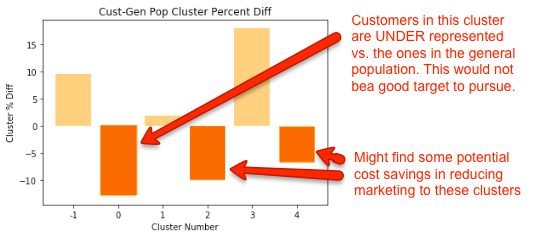

In our analysis after we trace back from the cluster level we find this maps to a PCA component that is most influential comes from component 0

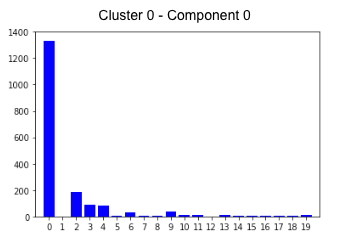

The kinds of people that are part of this cluster that reflected in the customer data compared 
to the general population are as follows:

The following columns that have the most POSITIVE contribution to this cluster:
- 1st  most column contribution LP_STATUS_GROB_1.0 (Social status - low to top income earners)
- 2nd  most column contribution HH_EINKOMMEN_SCORE (Estimated household net income highest to very low income) 
- 3rd  most column contribution CAMEO_INTL_2015_HH (Wealthy to poorer Households)  


The following columns that have the most NEGATIVE contribution to this cluster:
- 3rd Least column contribution KBA05_ANTG1 (Number of 1-2 family houses - lower to very high share 1-2 family homes)         
- 2nd Least column contribution FINANZ_MINIMALIST (low financial interest)   
- 1st Least column contribution MOBI_REGIO (Movement patterns - very high to very low movement)         


### Discussion 3.3: Compare Customer Data to Demographics Data

Here I will describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company.

Seems like the audience that are popular with the products of this mail-order company are described as coming from the third principal component (comp 2). We see the three most influential features in the POSITIVE direction are low affinity to individuals being of personality that are considered SEMIO_VERT (dreamful), SEMIO_FAM (family-oriented) and SEMIO_SOZ (socially-minded) verses the opposite of being SEMIO_DOM (dominant-minded), SEMIO_KAEM (combative) and ANREDE_KZ (male).

So the recommendations is for the company to increase their efforts to marketing more to a target audience of females that are socially oriented and have families. Also, decreasing efforts in marketing to the opposite market may help with cost savings, ie. less marketing to males that has a dominating and combative attitude that are not to be popular in social and family surroundings.


As for the the audience that is considered unpopular with the products of this mail-order company are described as coming from the first principal component (comp 0). We see the three most influencial features in the POSITIVE direction are 1st most - LP_STATUS_GROB_1.0 (Social status of top income earners), 2nd - HH_EINKOMMEN_SCORE(Estimated household net of income high incomes), and 3rd most - CAMEO_INTL_2015_HH (Wealthy  Households)
For the first principal component (comp 0) we see the three most influencial features in the NEGATIVE direction are 3rd Least - KBA05_ANTG1 (Very high share of 1-2 family homes), 2nd Least - FINANZ_MINIMALIST (low financial interest) and 1st Least feature is MOBI_REGIO (Movement patterns - very high movement).

So the recommendations here is for the company to decrease their efforts to marketing less to a target audience of 
wealthy households with top earning indivduals. This makes sense, since these individuals don't feel a strong attraction to save money as they have a lot of disposal income. On the otherhand, the company to consider marketing the groups in the negative influence of this component. Ie. they should increase their efforts to target individuals that are part sharing family homes with others, highly minimalist as they don't have alot of money to buy things and high movement habits due to needing to maybe find cheaper or safer housing, or even evictions. All characteristics of a lower social class. These are individuals that are looking for products and services that can better their lives as they don't have as much as the upper echelon of society. 

## Resources

1) PCA on Categorical Data - not the best choice!
https://stats.stackexchange.com/questions/5774/can-principal-component-analysis-be-applied-to-datasets-containing-a-mix-of-cont

2) Insert a Column - https://stackoverflow.com/questions/18674064/how-do-i-insert-a-column-at-a-specific-column-index-in-pandas 

3) Get Column location - https://stackoverflow.com/questions/13021654/get-column-index-from-column-name-in-python-pandas

4) StandardScaler Transform - https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.htm

5) Barchart coloring - https://stackoverflow.com/questions/42656585/barplot-colored-according-a-colormap